# Final Project Submission

Please fill out:
* Student name: Jessica Miles
* Student pace: full time
* Scheduled project review date/time: 6/23: 4 PM
* Instructor name: James Irving

# INTRODUCTION

## Business Problem


Knowing what customers like best about your products and brand is important if you want to both retain existing customers as well as attract new ones. Likewise, knowing what customers do not like about your brand or products will illuminate areas where change may be needed, especially if your competitors do well in those areas.

Customers may provide feedback directly to you in the form of responses to surveys you conduct, and voluntary product reviews. However, it can be difficult to design surveys that completely avoid response bias, and voluntary product reviews tend to skew towards more polarized opinions. 

Analyzing what the general public says about your brand and products on platforms such as Twitter may yield feedback other methods miss. But since it would be cost and time-prohibitive to have human beings analyze and classify large volumes of tweets, a more automated method is needed.

This analysis is a proof-of-concept to determine if a machine learning model can be trained to predict positive or negative sentiment. There are two primary objectives that an analysis leveraging machine learning would need to meet:

1. Starting with a corpus of tweets, separate out those in which a positive or negative sentiment towards a brand or product is expressed from those in which the sentiment or neutral, or the sentiment is directed elsewhere.
2. Provide useful or actionable insights into the keywords, topics, or concepts that drive negative versus positive sentiment.


# OBTAIN

:## Data Understanding

I will use a dataset consisting of about 9,000 tweets that appear to have been made during a SXSW event, and most of which are related to either Apple or Google brands or products. 

The tweets were coded by humans, who were asked to classify them based on emotion related to brands and products. Here is the brief overview from [data.world](https://data.world/crowdflower/brands-and-product-emotions)

>Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. 

I will focus on identifying the sentiment as opposed to determining whether the primary target of that sentiment is an Apple or Google product.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import html
import string
import joblib
from chardet.universaldetector import UniversalDetector

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import TweetTokenizer, word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud

import spacy

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

%matplotlib inline

In [2]:
pd.set_option("display.max_colwidth",150)

In [3]:
# try to detect chatacter encoding of the file
detector = UniversalDetector()

for line in open('data/judge-1377884607_tweet_product_company.csv', 'r+b').readlines():
    #print(line)
    detector.feed(line)
    if detector.done: break
        
detector.close()
print(detector.result)


{'encoding': 'Windows-1254', 'confidence': 0.43036719349968755, 'language': 'Turkish'}


That wasn't especially helpful. I tried cp1254 codec and it was not successful.

In [4]:
# read in data. Had to switch to latin_1 encoding because encountered errors
# with default UTF-8 and windows 1254

df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',
                encoding='latin_1')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [6]:
# check out the one null in the tweet_text column
df.loc[df['tweet_text'].isna()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,NaN,NaN,No emotion toward brand or product


In [7]:
# verified it's blank in the source CSV as well. Going to drop it.
df.dropna(subset=['tweet_text'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [8]:
# rename the columns to be less verbose
col_dict = {'emotion_in_tweet_is_directed_at':'product',
           'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}
df.rename(columns=col_dict, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  9092 non-null   object
 1   product     3291 non-null   object
 2   emotion     9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


In [9]:
# check out classes
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [10]:
# what are the values in the product column? How do they match up to emotions?
df.groupby(by=['emotion', 'product'], dropna=False).count()

tweet_text
emotion                            product                                    
I can't tell                       Apple                                     2
                                   Google                                    1
                                   Other Google product or service           1
                                   iPad                                      4
                                   iPhone                                    1
                                   NaN                                     147
Negative emotion                   Android                                   8
                                   Android App                               8
                                   Apple                                    95
                                   Google                                   68
                                   Other Apple product or service            2
                                   Other Google product or service          47
                                   iPad                                    125
                                   iPad or iPhone App                       63
                                   iPhone                                  103
                                   NaN                                      51
No emotion toward brand or product Android                                   1
                                   Android App                               1
                                   Apple                                    21
                                   Google                                   15
                                   Other Apple product or service            1
                                   Other Google product or service           9
                                   iPad                                     24
                                   iPad or iPhone App                       10
                                   iPhone                                    9
                                   NaN                                    5297
Positive emotion                   Android                                  69
                                   Android App                              72
                                   Apple                                   543
                                   Google                                  346
                                   Other Apple product or service           32
                                   Other Google product or service         236
                                   iPad                                    793
                                   iPad or iPhone App                      397
                                   iPhone                                  184
                                   NaN                                     306

In [274]:
# let's get a sample of "I can't tell"
df.loc[df['emotion']=="I can't tell",['tweet_text']][:10]

,tweet_text
89,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh
101,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow
236,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw"
340,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw
367,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link}
412,SYD #SXSW crew your iPhone extra juice pods have been procured.
440,Why Barry Diller thinks iPad only content is nuts @mention #SXSW {link}
486,Gave into extreme temptation at #SXSW and bought an iPad 2... #impulse
638,Catch 22Û_ I mean iPad 2 at #SXSW : {link}
703,Forgot my iPhone for #sxsw. Android only. Knife to a gun fight


Interesting. To me, these sample tweets labeled 'I can't tell' can all be classified pretty easily. However, they tend to be either neutral, or include nuanced sentiment such as sarcasm.

I'm definitely questioning the quality of the labeling at this point; if it was crowd sourced to a group of people I would have at least expected a second pass QC team to have gone through the 'I can't tell' set and classified them. The fact that they did not may mean that there WAS no second pass QC step, in which case the consistency and quality of this coding may be mediocre.

In [12]:
# for tweets with positive sentiment but no product listed, what are those about?
df.loc[(df['emotion']=='Positive emotion') & (df['product'].isna()), 
       ['tweet_text', 'emotion']]

,tweet_text,emotion
46,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},Positive emotion
112,Spark for #android is up for a #teamandroid award at #SXSW read about it here: {link},Positive emotion
131,Does your #SmallBiz need reviews to play on Google Places...We got an App for that..{link} #seo #sxsw,Positive emotion
157,@mention #SXSW LonelyPlanet Austin guide for #iPhone is free for a limited time {link} #lp #travel,Positive emotion
337,First day at sxsw. Fun final presentation on Google Doodles. #GoogleDoodle #sxsw,Positive emotion
...,...,...
8898,"@mention What's the wait time lookin like? The Apple Store up north is already sold out, any word on the #SXSW inventory?",Positive emotion
9011,apparently the line to get an iPad at the #sxsw store grew by 2 blocks to 5 blocks in the past 30 mins. WUT.,Positive emotion
9049,@mention you can buy my used iPad and I'll pick one up tomorrow ;-) #sxsw,Positive emotion
9052,@mention You could buy a new iPad 2 tmrw at the Apple pop-up store at #sxsw: {link},Positive emotion


In [275]:
# for tweets with negative sentiment but no product listed, what are those about?
df.loc[(df['emotion']=='Negative emotion') & (df['product'].isna()), 
       ['tweet_text', 'emotion']]

,tweet_text,emotion
63,Again? RT @mention Line at the Apple store is insane.. #sxsw,Negative emotion
67,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",Negative emotion
102,Know that &quot;dataviz&quot; translates to &quot;satanic&quot; on an iPhone. I'm just sayin'. #sxsw,Negative emotion
416,Shipments daily - follow @mention #AppleATXdt 4 updates RT @mention Pop-up Apple Store seems to be out of pop-up iPad2s. #SXSW,Negative emotion
565,Length of Google penalty based on severity of breach of webmaster guidelines. i.e.white text on white bgr might get 30 day pen. #sxsw #qagb,Negative emotion
910,"Hm? Do we need another 1? RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Negative emotion
928,"Google is not launching anything during #sxsw, just partying {link} #circles",Negative emotion
1032,BRILLIANT READ: Attention Marketers and Media Professionals: the iPad won't save you by @mention {link} #usguys #SxSW,Negative emotion
1067,My iPhone says it can't connect to the Internet even though #sxsw wifi works great on my computer. Any suggestions?,Negative emotion
1281,Trying to update software (4.0) on iPhone to download #sxsw app. But so far no luck - wonder if it's because phone is from Mexico.,Negative emotion


OK, I am also disagreeing with the coding on some of these as well. 

Some I don't think have a positive emotion towards a product at all, such as rows 46, 131, 157, and 9054. Simply mentioning an app for a platform doesn't necessarily mean positive emotion was directed towards the app.

Others I can believe are slightly positive, but it's also clear which product or brand the emotion is directed towards, so I'm not sure why that is missing. Row 337 is definitely about a Google product that was showcased in a presentation, and 9049 is clearly related to an iPad.

# SCRUB

## Data Preparation

I performed some preprocessing on the tweets in doc form (i.e. before tokenizing). I performed these steps on all of the tweets regardless of class label, so that I can use any or all of them in my models later.

The main steps I did in this stage were:
- Checked for HTML tags (there were none)
- replaced HTML character codes with ASCII
- removed non-ASCII characters
- removed control characters
- Removed words that consisted of only numbers
- replaced URLs and links with a `{link}` placeholder

I considered doing some steps such as removing hashtags up front, but then I wouldn't be able to see the results of having them in. Instead, I copied the hashtags into a separate column so I could see what the most common ones were.

Tasks such as stopwords removal and handle (@mention) removal will be handled in preprocessing using the NLTK `TweetTokenizer` and sklearn `CountVectorizer`.


In [13]:
# Make a copy of the tweet text, so I can keep the original pristine
df['cleaned'] = df['tweet_text']
df['cleaned'].head()

0                .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.
1    @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW
2                                                                @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
3                                                             @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4            @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)
Name: cleaned, dtype: object

In [14]:
# check for duplicates
df.duplicated(subset=['tweet_text'], keep='first').sum()

27

In [15]:
# Take a look at duplicate rows
dupes = df.duplicated(subset=['tweet_text'], keep=False)
df.loc[dupes.loc[dupes==True].index].sort_values(by='tweet_text')

,tweet_text,product,emotion,cleaned
7,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan"
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive emotion,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan"
466,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion,"Before It Even Begins, Apple Wins #SXSW {link}"
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion,"Before It Even Begins, Apple Wins #SXSW {link}"
9,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive emotion,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear
774,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,No emotion toward brand or product,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw"
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",NaN,No emotion toward brand or product,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw"
17,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative emotion,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone
8483,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone,iPhone,Negative emotion,I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone


Definitely seeing some inconsistencies in coding the exact same tweets. Keeping this in mind, but going to remove the duplicates.

In [16]:
# drop duplicates
df.drop_duplicates(subset=['tweet_text'], keep='first', inplace=True)
# check for duplicates
df.duplicated(subset=['tweet_text'], keep='first').sum()

0

In [17]:
df.reset_index(drop=True, inplace=True)

## Clean non-ASCII, HTML charcodes, and links

In [18]:
# check for literal (unescaped) open or closing HTML tags
df[df['tweet_text'].str.contains("[<>]")]

,tweet_text,product,emotion,cleaned


Since there are no "<>" characters in any of the tweets, I will not add anything to remove HTML tags from the text when I clean it. 

In [19]:
# check for links or URLs
df[df['tweet_text'].str.contains("http[^ ]+|www\.[^ ]+")]

,tweet_text,product,emotion,cleaned
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd
7,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB,iPad or iPhone App,Positive emotion,Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB
10,Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.,Android App,Positive emotion,Find &amp; Start Impromptu Parties at #SXSW With @HurricaneParty http://bit.ly/gVLrIn I can't wait til the Android app comes out.
11,"Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.",Android App,Positive emotion,"Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date."
12,Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out. RT @hamsandwich via @ischafer =&gt;http://bit.ly/aXZwxB,Other Google product or service,Positive emotion,Gotta love this #SXSW Google Calendar featuring top parties/ show cases to check out. RT @hamsandwich via @ischafer =&gt;http://bit.ly/aXZwxB
13,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l,iPad or iPhone App,Positive emotion,Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l
14,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw",iPad or iPhone App,Positive emotion,"haha, awesomely rad iPad app by @madebymany http://bit.ly/hTdFim #hollergram #sxsw"
15,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw
18,Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV,iPad or iPhone App,Positive emotion,Must have #SXSW app! RT @malbonster: Lovely review from Forbes for our SXSW iPad app Holler Gram - http://t.co/g4GZypV
22,"Photo: Just installed the #SXSW iPhone app, which is really nice! http://tumblr.com/x6t1pi6av7",iPad or iPhone App,Positive emotion,"Photo: Just installed the #SXSW iPhone app, which is really nice! http://tumblr.com/x6t1pi6av7"


I definitely do have URLs, which I will remove.

In [20]:
# check for non-ASCII characters
# regex from https://stackoverflow.com/questions/2124010/grep-regex-to-match-non-ascii-characters

df[df['tweet_text'].str.contains('[^\x00-\x7F]+')]

,tweet_text,product,emotion,cleaned
37,@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW,Google,Negative emotion,@mention - False Alarm: Google Circles Not Coming NowÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW
40,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether youÛªre getting friend... {link}",NaN,No emotion toward brand or product,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether youÛªre getting friend... {link}"
41,Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and weÛªll make you one!,NaN,No emotion toward brand or product,Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and weÛªll make you one!
44,#IPad2 's Û÷#SmartCoverÛª Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW,iPad or iPhone App,Positive emotion,#IPad2 's Û÷#SmartCoverÛª Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW
45,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link},NaN,Positive emotion,Hand-Held Û÷HoboÛª: Drafthouse launches Û÷Hobo With a ShotgunÛª iPhone app #SXSW {link}
...,...,...,...,...
8897,umm that would be @mention ÛÏ@mention I keep winning shit! Thanks @mention for the killer iPad case. #sxswÛ,Other Apple product or service,Positive emotion,umm that would be @mention ÛÏ@mention I keep winning shit! Thanks @mention for the killer iPad case. #sxswÛ
8917,FestivalExplorer iPhone App Finally Solves SXSW {link} #music #musica #musiek #musique #musik #app #sxsw #Ù_¾¬â #Ù_¾´_ #Î¥É,iPad or iPhone App,Positive emotion,FestivalExplorer iPhone App Finally Solves SXSW {link} #music #musica #musiek #musique #musik #app #sxsw #Ù_¾¬â #Ù_¾´_ #Î¥É
8935,"Group #Texting War Heats Up: Fast Society Launches New Android App, Updates iPhone App: #SXSWÛ_ {link}",Android App,Positive emotion,"Group #Texting War Heats Up: Fast Society Launches New Android App, Updates iPhone App: #SXSWÛ_ {link}"
8954,"In case my fairy god mother = reading mail; my ÌÙ±G wish this week is 2 go 2 #sxsw Ï for the #Android ÏÎ Dev Ïà Meetup. @mention Hilton, Sat....",NaN,No emotion toward brand or product,"In case my fairy god mother = reading mail; my ÌÙ±G wish this week is 2 go 2 #sxsw Ï for the #Android ÏÎ Dev Ïà Meetup. @mention Hilton, Sat...."


In [21]:
# How would the encode/decode trick work? would it give me better text than
# simply removing the non-ASCII chars?
doc = df.at[38, 'tweet_text']
doc = doc.encode('ascii', 'ignore').decode()
doc

'VatorNews - Google And Apple Force Print Media to Evolve? {link} #sxsw'

The problem I have with the non-ASCII characters is that they often seem to represent apostrophes and quotation marks. I can't find an encoding that will show them properly in python, or in a SublimeText when I open the raw file. 

For now I'm going to replace the non-ASCII characters with spaces because I think replacing them with nothing will lead to weird words.

In [22]:
def clean_docs(doc):
    """
    Performs a few basic cleaning steps:
    - Unescapes any escaped HTML (i.e. `&amp;` for ampersand)
    - Replaces URLs with the `{link}` placeholder text
    - Replaces non-ASCII characters with spaces
    - Replaces any control characters with spaces
    - Finally, cleans up any instances of multiple spaces that might have
    been created during this process, replacing with a single space
    
    Takes in a document at a time, and returns the cleaned document text as 
    a string.
    """
    # unescape HTML characters
    doc = html.unescape(doc)
    
    # remove URLs and links, replacing them with existing placeholder
    urls = re.findall("http[^ ]+|www\.[^ ]+", doc)
    for url in urls:
        doc = str.replace(doc, url, '{link}')
    
    # replace non-ASCII characters with space
    doc = re.sub(r"[^\x00-\x7F]+", ' ', doc)
    
    # replace ASCII control characters with space
    doc = re.sub(r"[\x00-\x1F]", ' ', doc)
    
    # remove multiple spaces, which will exist after all this replacing words
    doc = re.sub(r"[ ]{2,}", ' ', doc)
    
    return doc

In [23]:
# map doc cleaning function onto 'cleaned' column
df['cleaned'] = df['cleaned'].map(lambda x: clean_docs(x))
df

,tweet_text,product,emotion,cleaned
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)"
...,...,...,...,...
9060,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Ipad everywhere. #SXSW {link}
9061,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",NaN,No emotion toward brand or product,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles"
9062,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev",NaN,No emotion toward brand or product,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. ""We're operating w/out data."" #sxsw #health2dev"
9063,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,NaN,No emotion toward brand or product,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.


In [24]:
# specifically check on a few rows
df.loc[[44, 8944, 8981]]

,tweet_text,product,emotion,cleaned
44,#IPad2 's Û÷#SmartCoverÛª Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW,iPad or iPhone App,Positive emotion,#IPad2 's #SmartCover Opens to Instant Access - I should have waited to get one! - {link} #apple #SXSW
8944,Biomimicry as the basis of design and problem solving. Google studying flocking and swarming behavior to understand collab. Brilliant. #sxsw,Google,Positive emotion,Biomimicry as the basis of design and problem solving. Google studying flocking and swarming behavior to understand collab. Brilliant. #sxsw
8981,Very happy that Discovr has been named as one of the top ten must-have apps for iPad 2 :) I just have to fight my way thru the queue! #sxsw,iPad or iPhone App,Positive emotion,Very happy that Discovr has been named as one of the top ten must-have apps for iPad 2 :) I just have to fight my way thru the queue! #sxsw


In [25]:
# check for links or URLs after cleaning
df[df['cleaned'].str.contains("http[^ ]+|www\.[^ ]+")]

,tweet_text,product,emotion,cleaned


In [26]:
def get_pattern_hits(doc, pattern, out_type):
    """Takes in a regex pattern and a string of text, and checks for the 
    presence of the pattern in the string. 
    
    Returns a copy of the text string with the pattern replaced with spaces, 
    and the matches. See `out_type` for available formats for the match output.
    
    *** Arguments
    
    doc: string. Text to be searched for the pattern.
    
    pattern: string, regex pattern. Pattern to be searched for in the string.
    
    out_type: string. Indicate how / whether the matches on the pattern
    should be returned.
    
        If `out_type` = `list`, each match on the pattern is saved into a list
        and the list is returned. 
        
        If `out_type` = `string`, each match on the pattern is saved into a 
        string separated by spaces and that string is returned. 

        If `out_type` = `boolean`, the output is just
        True if there was at least one match, and false if there were none.

        If `out_type` = `none`, the pattern matches are simply removed from the
        text string and not logged in any way.
    """
    
    # determine the variable type for recording hits
    if out_type=='list': 
        hits = []
    elif out_type=='string': 
        hits = ""
    elif out_type=='bool':
        hits = False
    elif out_type=='none':
        hits = None
        
    # search for regex pattern in doc
    pattern_hits = re.findall(pattern, doc)

    if len(pattern_hits) > 0:
        # replace the hits in the original doc string
        # need to use the re version otherwise substrings won't be replaced 
        # correctly!
        doc = re.sub(pattern, ' ', doc)

        # replace multiple spaces with a single space
        doc = re.sub(r"(\s{2,})", ' ', doc)

        # Update appropriate hits variable
        for hit in pattern_hits:
            if out_type=='list':
                hits.append(hit)
            elif out_type=='string':
                hits = hits + ' ' + hit
            elif out_type=='bool':
                hits = True

        if out_type=='list':
            hits = list(set(hits))
                 
    return doc, hits

In [27]:
def pattern_match_in_df(df, doc_col, hit_col, pattern, out_type='list', 
                        replace=True):
    """Loops through values in a particular dataframe columns, and searches
    for regex pattern matches. 
    
    Returns the same dataframe, updated with new `hit_col`, and replaced
    `doc_col`, depending on arguments passed.
    
    *** Arguments
    
    df: Dataframe containing the `doc_col` to be searched.
    
    doc_col: String. Name of the dataframe column containing the text to be
    searched for the pattern.
    
    hit_col: String. Name of the column which should be added to the dataframe
    when it's returned, containing the pattern hit information.
    
    pattern: string, regex pattern. Pattern to be searched for in the string.
    
    out_type: string. See `get_pattern_hits` documentation for details.
    
    replace: Boolean, default True.
    
    Use `replace=True` to have the matches be replaced with spaces, and the
    original `doc_col` replaced with a new one with matches removed.
    If `replace=False`, the `doc_col` will not be updated, and matches will
    only be logged in the new `hit_col`.
    
    """
    updates = []
    
    # loop through each row in the dataframe to process its record
    for i in df.index:
        new_doc, hits = get_pattern_hits(df.at[i, doc_col], pattern, out_type)
        updates.append([new_doc, hits])
    
    # create a dataframe out of the updated info
    df_new = pd.DataFrame(updates, columns=[doc_col, hit_col])

    # if we were told not to output the hits, drop the hits column
    if out_type=='none':
        df_new.drop(columns=[hit_col], inplace=True)
    
    # if we were told not to replace the hits in the original text column,
    # drop the new doc column
    if not replace:
        df_new.drop(columns=[doc_col], inplace=True)
    
    if len(df_new.columns) > 0:
        df = df.join(df_new, lsuffix='_old', how='inner')
        if replace:
            df.drop(columns=[f"{doc_col}_old"], inplace=True)
    else:
        print("Dataframe was returned as-is based on arguments passed.")
            
    return df


## Remove words that are all numbers

In [28]:
# remove numbers
df = pattern_match_in_df(df, doc_col='cleaned', hit_col='_', 
                pattern=r"(?:^|\s)([.:$%]*[0-9]+[.:$%]*[0-9]*)\b", 
                out_type='none', replace=True)
df[['tweet_text', 'cleaned']]

,tweet_text,cleaned
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW","@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW"
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)","@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)"
...,...,...
9060,Ipad everywhere. #SXSW {link},Ipad everywhere. #SXSW {link}
9061,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles","Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles"
9062,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev","Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. ""We're operating w/out data."" #sxsw #health2dev"
9063,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.


In [29]:
# I don't see many numbers in the head/tail cells, so let's find some
df.loc[df['tweet_text'].str.contains(r"(?:^|\s)([.:$%]*[0-9]+[.:$%]*[0-9]*)\s"), 
       ['tweet_text', 'cleaned']]

/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_text,cleaned
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW."
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.
23,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Really enjoying the changes in Gowalla for Android! Looking forward to seeing what else they & Foursquare have up their sleeves at #SXSW
28,"They were right, the @gowalla 3 app on #android is sweeeeet! Nice job by the team there. #sxsw","They were right, the @gowalla app on #android is sweeeeet! Nice job by the team there. #sxsw"
42,Mashable! - The iPad 2 Takes Over SXSW [VIDEO] #ipad #sxsw #gadgets {link},Mashable! - The iPad Takes Over SXSW [VIDEO] #ipad #sxsw #gadgets {link}
...,...,...
9024,@mention You could buy a new iPad 2 tmrw at the Apple pop-up store at #sxsw: {link},@mention You could buy a new iPad tmrw at the Apple pop-up store at #sxsw: {link}
9026,"Guys, if you ever plan on attending #SXSW, you need 4 things, skinny jeans, flannel shirt, beard and an iPad #imanoutcast...","Guys, if you ever plan on attending #SXSW, you need things, skinny jeans, flannel shirt, beard and an iPad #imanoutcast..."
9035,@mention You should get the iPad 2 to save your back from lugging the laptop #SXSW #SXSWMyMistake,@mention You should get the iPad to save your back from lugging the laptop #SXSW #SXSWMyMistake
9044,@mention your iPhone 4 cases are Rad and Ready! Stop by tomorrow to get them! #Sxsw #zazzlesxsw #sxswi {link},@mention your iPhone cases are Rad and Ready! Stop by tomorrow to get them! #Sxsw #zazzlesxsw #sxswi {link}


## Log hashtags in a separate column

In [30]:
df = pattern_match_in_df(df, doc_col='cleaned', hit_col='hashtags', 
                pattern=r"(?:^|\s)(#[a-zA-Z0-9_-]+)", 
                out_type='string', replace=False)
df[['tweet_text', 'cleaned', 'hashtags']]

,tweet_text,cleaned,hashtags
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",#RISE_Austin #SXSW
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW","@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",#SXSW
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.,#iPad #SXSW
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,#sxsw
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)","@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",#SXSW
...,...,...,...
9060,Ipad everywhere. #SXSW {link},Ipad everywhere. #SXSW {link},#SXSW
9061,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles","Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",#sxsw #google #circles
9062,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. &quot;We're operating w/out data.&quot; #sxsw #health2dev","Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. ""We're operating w/out data."" #sxsw #health2dev",#sxsw #health2dev
9063,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,#SXSW


# EXPLORE

Now that I've done some basic cleaning, I'd like to look at the characteristics of the corpus, such as:
- class balances
- distribution of tweet lengths
- most common words before and after removing stopwords and punctuation
- most common words in the different classes
- most common hashtags in the different classes

In [31]:
def generate_wordcloud(docs, cmap, stopwords, min_font_size=14, n_grams=True, 
                       title='Word cloud'):
    """Generate a wordcloud from a list of pre-tokenized words. Words will be
    joined into a space-delimited string inside the function.
    """
    cloud = WordCloud(colormap=cmap, width=600, height=400, 
                      prefer_horizontal=0.95, min_font_size=min_font_size,
                     collocations=n_grams)\
                      .generate_from_text(" ".join(docs))

    fig, ax = plt.subplots(figsize=(10, 6))

    # Display the generated image:
    ax.imshow(cloud)
    ax.set_axis_off()
    ax.set_title=(title)
    ax.margins(x=0, y=0);

In [32]:
def generate_freqs_wordcloud(df, word_col, freq_col, cmap, min_font_size=14,
                            title='Word cloud'):
    """Generate a wordcloud from a dataframe where one column holds the words
    and another column holds the frequency or weight. The dictionary for the
    wordcloud is generated inside the function.
    """
    freq_dict = pd.Series(df[freq_col].values,index=df[word_col]).to_dict()
    
    cloud = WordCloud(colormap=cmap, width=600, height=400, 
                      prefer_horizontal=0.95, min_font_size=min_font_size,
                     collocations=False).generate_from_frequencies(freq_dict)

    fig, ax = plt.subplots(figsize=(10, 6))

    # Display the generated image:
    ax.imshow(cloud)
    ax.set_axis_off()
    ax.set_title=(title)
    ax.margins(x=0, y=0);

In [33]:
def plot_wordfreqs(df, word_col, freq_col, top_n, sub_title):
    """Displays a horizontal bar plot of words frequencies from the `top_n`
    words in a corpus.
    
    `df` should be a DataFrame where `word_col` is the column name containing 
    the word or ngram text, and `freq_col` is the column name containing the 
    frequency.
    """
    
    with sns.plotting_context(context='talk'):
        fig, ax = plt.subplots(figsize=(8, top_n / 2.5))
        sns.barplot(data=df,
                    y=df[word_col][:top_n], 
                    x=df[freq_col][:top_n], color='blue')
        ax.set_title(f"Top {top_n} Words\n{sub_title}")

In [34]:
def tokenize_corpus_dict_tweet(df, target_vals, stop_list=None, 
                               verbose=True, target_col='emotion',
                              doc_col='cleaned'):
    """ Tokenizes text and separates the tokens. Returns a dictionary where the
    keys are target class labels and the values are a list of tokens within 
    the labeled class.
    
    `df` is a Dataframe with the document text and labels, and `doc_col` is the
    name of the column in which document text is stored.
    
    `target_vals` should be a list of the class labels; labels in `target_col` 
    but not in the `target_vals` list will be ignored.
    
    If `stop_list` (type=list) provided, those words or tokens will be removed
    from the returned dict.
    """
    tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

    # generate corpus for each emotion
    corpus_per_target = {}

    for val in target_vals:
        
        if verbose:
            print(f"Starting target val: {val}")

        # get series of text docs per target_val
        docs = df.loc[df[target_col]==val, doc_col]

        # loop through docs and tokenize each one
        corpus = []

        i = 0
        for doc in docs:
            # tokenize using tweet tokenizer
            tokens = tweettokenizer.tokenize(doc)
            
            # remove stop words if needed
            if not stop_list == None:
                tokens = [token for token in tokens if token not in stop_list]
            
            # remove words if they're just spaces!
            tokens.remove(' ') if ' ' in tokens else None
            
            corpus.extend(tokens)
            i += 1
            
            if verbose and (i % 1000 == 0):
                print(f"Processed {i} docs out of {len(docs)}...")

        # add corpus to dict
        corpus_per_target[val] = corpus
        
    if verbose:
        print(f"Done!")
    return corpus_per_target


## Generate initial stopwords and punctuation lists

In [35]:
# starting with nltk's stopwords list
nltk_stopwords = stopwords.words('english')
nltk_stopwords.sort()
print(nltk_stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its', 'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she', "she's", 'should', "should've", 'shouldn', "shouldn't", 'so', 'some',

This has a lot of words that I think might be related to emotion towards a product, like negation (should / shouldn't, not), and words that can describe how or how much someone feels about something (so, under).

I'm going to create my own custom stopwords list that is much pared down.

In [36]:
# my much-pared-down stopwords list for testing
custom_stopwords = ['a','an','and','am','are','as','at','be','by','for',
                    'from','if','in','is','into','it',"it's",'its','itself',
                    'of','on','or','than','that','the','to']

In [37]:
# create full and custom punctuation list. Custom excludes ! and ?
punc = list(string.punctuation)
punc_custom = punc.copy()
punc_custom.remove('?')
punc_custom.remove('!')

print(punc)
print(punc_custom)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']
['"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


## Explore Classes

In [38]:
df['emotion'].value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

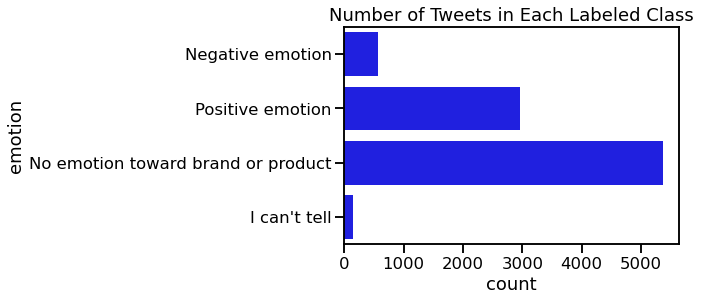

In [39]:
# Plot counts of each class
with sns.plotting_context(context='talk'):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.countplot(y=df['emotion'], orient='v', ax=ax, color='blue')
    ax.set_title('Number of Tweets in Each Labeled Class');

The vast majority of tweets are labeled 'No emotion towards brand or product'. 

Only 570 are negative, and 2978 are positive. Even adding those together, there are 50% more tweets with no emotion towards a brand or product, compared to those that have some emotion towards a brand or product.

I'm assuming (although I can't know for sure) that this corpus represents tweets with #sxsw hashtags during the festival one year, and which also had keywords or hashtags related to Apple or Google products. I will see if I can confirm this during my EDA.

In [40]:
# create a list of all the emotions
all_emotions = list(df['emotion'].value_counts().index)
all_emotions

['No emotion toward brand or product',
 'Positive emotion',
 'Negative emotion',
 "I can't tell"]

## Tweet Lengths

In [41]:
def count_words(doc):
    tokenizer_no_strip = TweetTokenizer(strip_handles=False)
    tokens = tokenizer_no_strip.tokenize(doc)
    return len(tokens)

df['raw_token_count'] = df['cleaned'].map(lambda x: count_words(x))
df.head()

,tweet_text,product,emotion,cleaned,hashtags,raw_token_count
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",#RISE_Austin #SXSW,28
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",#SXSW,26
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.,#iPad #SXSW,16
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,#sxsw,16
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",#SXSW,27


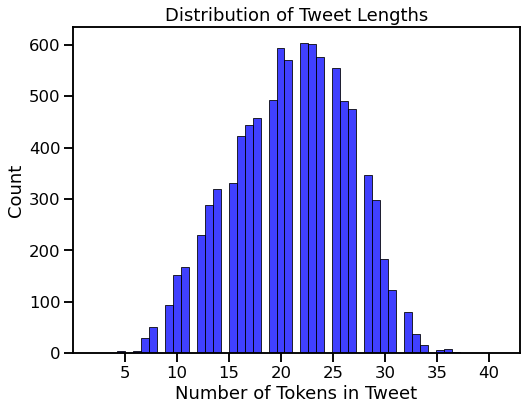

In [42]:
# visualize tweet length distribution
with sns.plotting_context(context='talk'):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(df['raw_token_count'], color='blue', ax=ax)
    ax.set_title('Distribution of Tweet Lengths')
    ax.set_xlabel('Number of Tokens in Tweet');

I see a pretty normal distribution here, where most tweets are 20-25 tokens long. This may be slightly different than the final words, since we haven't removed punctuation yet and right now it will be counted as a token in many cases.

## Explore Entire Corpus


### No stopwords or punctuation removed

In [43]:
# Create a dictionary of tokens with class labels as keys
# removing punctuation only
token_dict = tokenize_corpus_dict_tweet(df, all_emotions, 
                    stop_list=None, verbose=False)
token_dict['Positive emotion'][:5]

['know', 'about', '?', 'awesome', 'ipad']

In [44]:
# create list of all word frequencies in the corpus
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

len(all_tokens)


182652

In [45]:
# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

,Word,Count
0,#sxsw,9069
1,.,5885
2,the,4420
3,link,4336
4,},4321


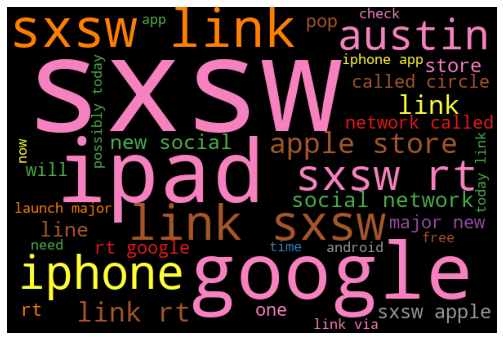

In [46]:
# Wordcloud for most common words in whole corpus, no stopwords
# or punctuation removed
generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16, 
                  title='Entire Corpus')

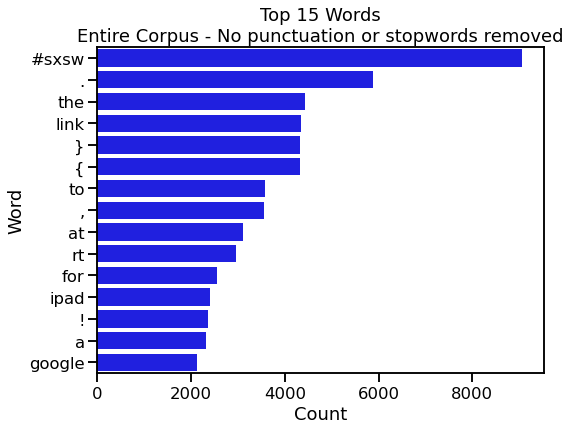

In [47]:
# Plot top 15 words across the entire corpus, no punctuation removed
plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - No punctuation or stopwords removed")

OK, the top words are mostly punctuation and stopwords.

I also see #sxsw, which isn't too surprising, since that's the event this corpus was focused on. I'm going to add #sxsw to the stopwords lists, and check out what we get after applying that and removing punctuation.

In [48]:
# extend custom stopwords list to include information about the event,
# which will likely be in common across all tweets
nltk_stopwords.extend(['austin', 'sxsw', '#sxsw'])
custom_stopwords.extend(['austin', 'sxsw', '#sxsw'])
print(custom_stopwords)

['a', 'an', 'and', 'am', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'if', 'in', 'is', 'into', 'it', "it's", 'its', 'itself', 'of', 'on', 'or', 'than', 'that', 'the', 'to', 'austin', 'sxsw', '#sxsw']


### Minimal custom stopwords and punctuation

In [49]:
# make a new dict with stopwords and punctuation removed
token_dict = tokenize_corpus_dict_tweet(df, all_emotions, 
                    stop_list=custom_stopwords + punc_custom, 
                                        verbose=False)
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

,Word,Count
0,link,4336
1,rt,2948
2,ipad,2407
3,!,2357
4,google,2125


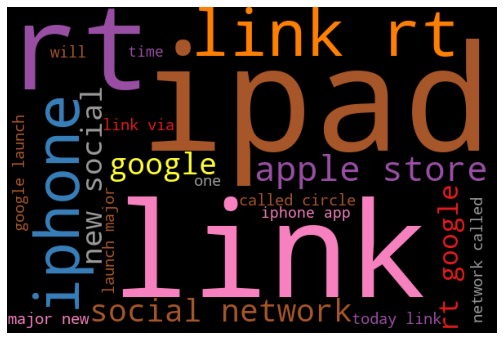

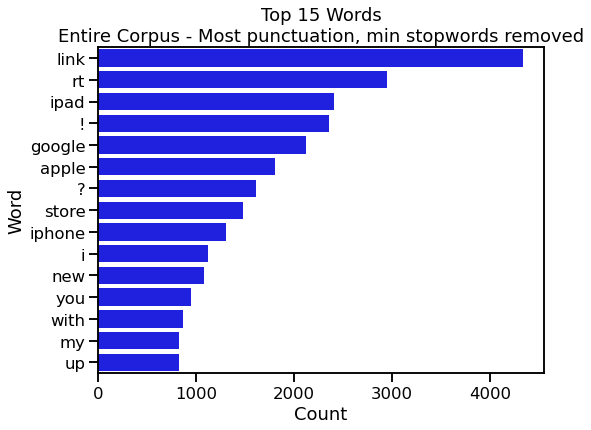

In [50]:
# Wordcloud for entire corpus, only custom stopwords and punct removed
generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=18)

plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - Most punctuation, min stopwords removed")

### NLTK stopwords and punctuation

In [51]:
# make a new dict with stopwords and punctuation removed
token_dict = tokenize_corpus_dict_tweet(df, all_emotions, 
                    stop_list=nltk_stopwords + punc_custom, 
                                        verbose=False)
all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

,Word,Count
0,link,4336
1,rt,2948
2,ipad,2407
3,!,2357
4,google,2125


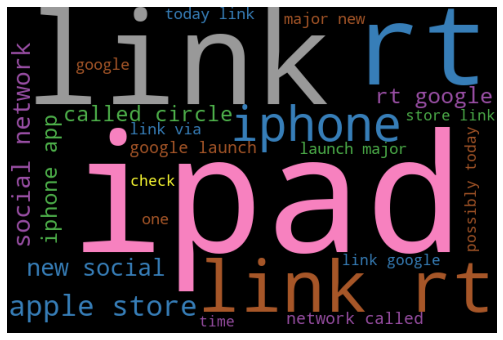

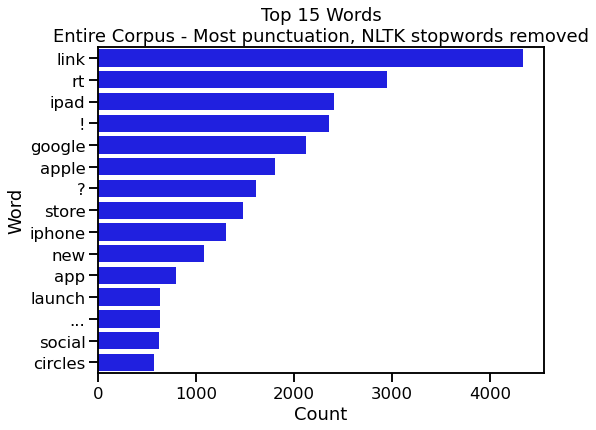

In [52]:
generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=18)

plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - Most punctuation, NLTK stopwords removed")

Hmm, so I still see `'link` and `rt` very high on the list, and know that link represents the links I replaced, and rt means a re-tweet.

I'm going to add both of those to my main stopwords lists.

I also see there are a bunch of Google and Apple products as well as brand names. I'm going to create separate lists of the product stopwords, so I can test removing them during modeling or not.

In [53]:
# create new stopwords list for product names and hashtags
product_stopwords = ["google", "apple", "ipad", "iphone", "android", "ipad2"]
hash_stop = ["#" + word for word in product_stopwords]
product_stopwords.extend(hash_stop)

# extend both existing stopwords lists to include placeholder text link and rt
nltk_stopwords.extend(['link', 'rt'])
custom_stopwords.extend(['link', 'rt'])

In [54]:
# Do all of the tweets contain one of the product stopwords?
# let's look at those that don't contain any of these words (will search substrings)
df.loc[df['cleaned'].str.contains('|'.join(product_stopwords), case=False)==False]

,tweet_text,product,emotion,cleaned,hashtags,raw_token_count
50,"ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,&amp; ppl who can help us JAM #libya #SXSW",NaN,No emotion toward brand or product,"@mention {link} <-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,& ppl who can help us JAM #libya #SXSW",#libya #SXSW,26
51,÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,NaN,No emotion toward brand or product,WHAT? _ {link} _ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,#edchat #musedchat #sxsw #sxswi #classical #newTwitter,13
52,".@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw",NaN,No emotion toward brand or product,".@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw",#sxsw,21
65,At #sxsw? @mention / @mention wanna buy you a drink. 7pm at Fado on 4th. {link} Join us!,NaN,No emotion toward brand or product,At #sxsw? @mention / @mention wanna buy you a drink. 7pm at Fado on 4th. {link} Join us!,#sxsw,24
70,Chilcott: @mention #SXSW stand talking with Blogger staff. Too late to win competition for best tweet mentioning @mention So no t-shirt.,NaN,No emotion toward brand or product,Chilcott: @mention #SXSW stand talking with Blogger staff. Too late to win competition for best tweet mentioning @mention So no t-shirt.,#SXSW,24
...,...,...,...,...,...,...
8904,Z6: No News is Good News {link} [codes valid: 4:00-7:59:59p 03/11/11] #infektd #sxsw #zlf,NaN,No emotion toward brand or product,Z6: No News is Good News {link} [codes valid: -7:59:59p /11/11] #infektd #sxsw #zlf,#infektd #sxsw #zlf,23
8908,CLIENT NEWS! @mention Releases &quot;Dope Melodies &amp; Heavy Bass&quot; &amp; Invades #SXSW -&gt; {link},NaN,No emotion toward brand or product,"CLIENT NEWS! @mention Releases ""Dope Melodies & Heavy Bass"" & Invades #SXSW -> {link}",#SXSW,19
8942,This is my 5th year downloading the #sxsw Music Torrent {link} ALL FREE and LEGAL! Great Music.,NaN,No emotion toward brand or product,This is my 5th year downloading the #sxsw Music Torrent {link} ALL FREE and LEGAL! Great Music.,#sxsw,21
8996,"by the way, we're looking for a spanish-speaking trend scout based in Austin -&gt; {link} #sxsw",NaN,No emotion toward brand or product,"by the way, we're looking for a spanish-speaking trend scout based in Austin -> {link} #sxsw",#sxsw,19


### All stopwords and punctuation

In [55]:
# make a new dict with stopwords and punctuation removed
token_dict = tokenize_corpus_dict_tweet(df, all_emotions, 
        stop_list=nltk_stopwords + punc_custom + product_stopwords, 
        verbose=False)

all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

,Word,Count
0,!,2357
1,?,1613
2,store,1477
3,new,1082
4,app,799


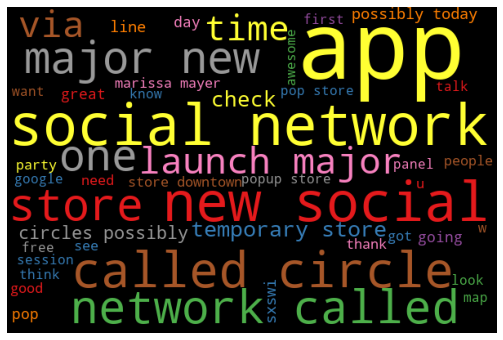

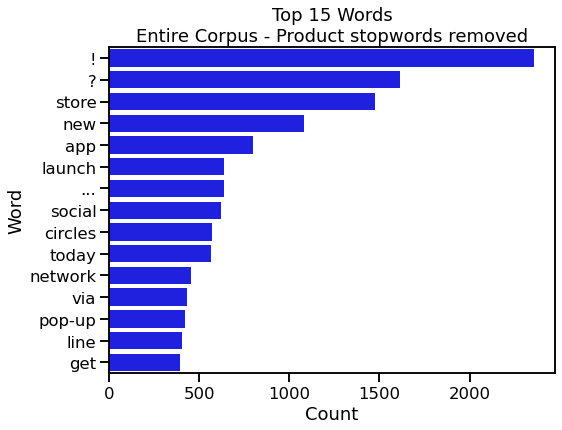

In [56]:
generate_wordcloud(docs=all_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=16)

plot_wordfreqs(corpus_freq_df, 'Word', 'Count', 15, 
               "Entire Corpus - Product stopwords removed")

### Most common hashtags

In [57]:
# make a new dict with stopwords and punctuation removed
token_hash_dict = tokenize_corpus_dict_tweet(df, all_emotions, 
        stop_list=nltk_stopwords + punc_custom + 
            product_stopwords + ['#sxswi', '#austin'], 
        verbose=False, doc_col='hashtags')

hash_tokens = []
[hash_tokens.extend(tokens) for tokens in token_hash_dict.values()]

hash_tokens[:5]

['#speechtherapy', '#iear', '#edchat', '#asd', '#gdgtlive']

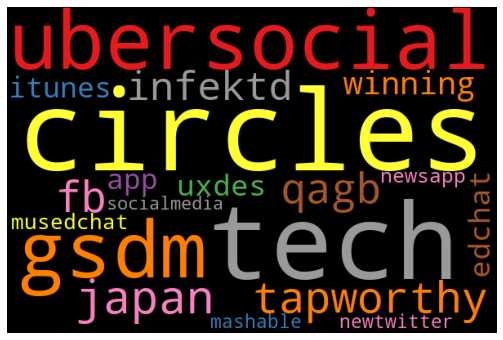

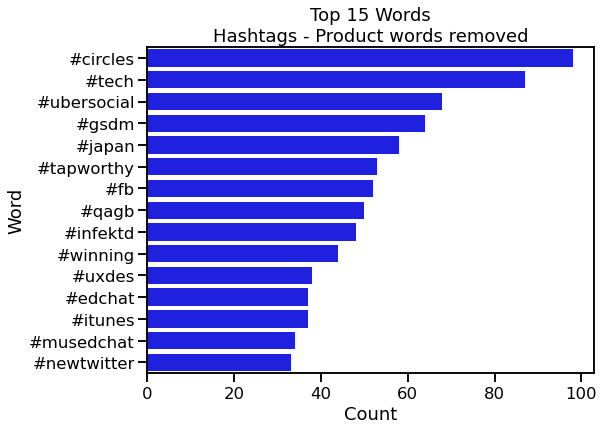

In [58]:
# get frequency distribution for entire corpus
hash_corpus = FreqDist(hash_tokens)

hash_freq_df = pd.DataFrame(hash_corpus.most_common(100),
                              columns=['Word','Count'])

generate_wordcloud(docs=hash_tokens, cmap="Set1", 
                   stopwords=None, min_font_size=18, n_grams=False)

plot_wordfreqs(hash_freq_df, 'Word', 'Count', 15, 
               "Hashtags - Product words removed")

## Explore Per Class Label

In [59]:
# Go back to only removing custom punctuation and stopwords
token_dict = tokenize_corpus_dict_tweet(df, all_emotions, 
        stop_list=custom_stopwords + punc_custom, verbose=False)

all_tokens = []
[all_tokens.extend(tokens) for tokens in token_dict.values()]

# get frequency distribution for entire corpus
all_corpus = FreqDist(all_tokens)

corpus_freq_df = pd.DataFrame(all_corpus.most_common(100),
                              columns=['Word','Count'])
corpus_freq_df[:5]

,Word,Count
0,ipad,2407
1,!,2357
2,google,2125
3,apple,1811
4,?,1613


### Positive

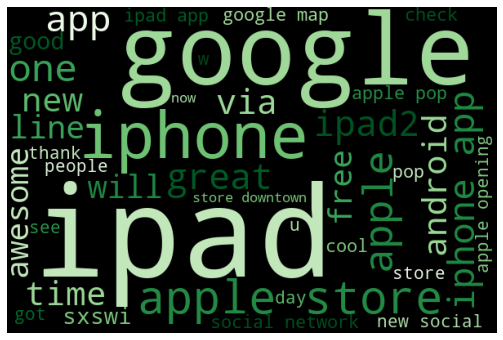

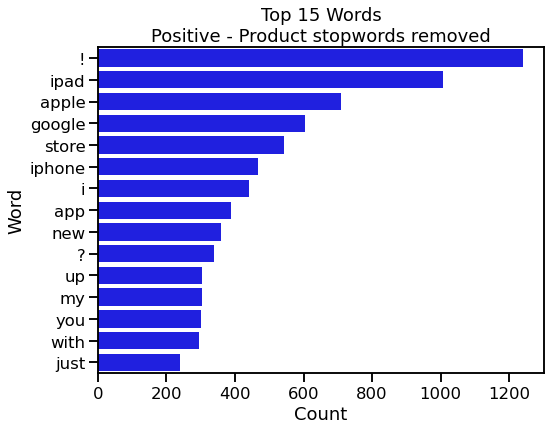

In [60]:
# get frequency distribution for positive emotions
pos = FreqDist(token_dict['Positive emotion'])

pos_freq_df = pd.DataFrame(pos.most_common(100),
                              columns=['Word','Count'])

generate_wordcloud(docs=token_dict['Positive emotion'], cmap="Greens", 
                   stopwords=None, min_font_size=14)

plot_wordfreqs(pos_freq_df, 'Word', 'Count', 15, 
               "Positive - Product stopwords removed")

### Negative

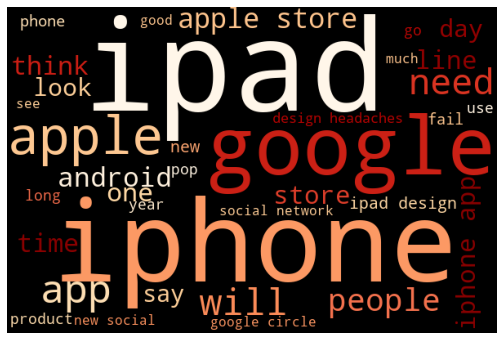

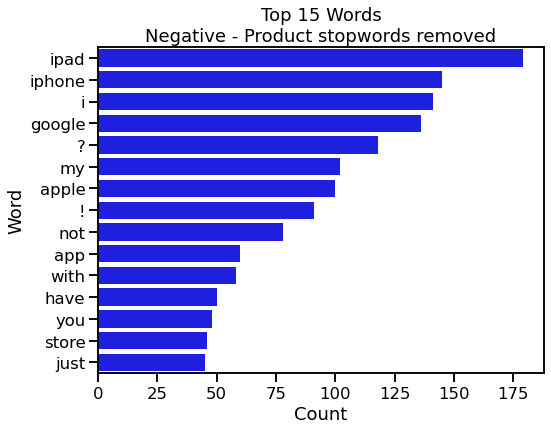

In [61]:
# get frequency distribution for negative emotions
neg = FreqDist(token_dict['Negative emotion'])

neg_freq_df = pd.DataFrame(neg.most_common(100),
                              columns=['Word','Count'])

generate_wordcloud(docs=token_dict['Negative emotion'], cmap="OrRd", 
                   stopwords=None, min_font_size=16)

plot_wordfreqs(neg_freq_df, 'Word', 'Count', 15, 
               "Negative - Product stopwords removed")

Comparing the positive and negative classes, `app`, `store`, `new`, and the punctuation `?`, `!`, and `...` are in the top of both.

The positive wordcloud that shows bigrams has `popup store` and `temporary store`, so people seem to be saying good things about that. `Map` and `free` also make an appearance in the positive word cloud.

In the negative wordcloud, I see `long`, `line`, `time`, `people`, and `wait`, so I wonder if some of the negative emotions are regarding lines to get into stores or events for the products. I also see `battery`, `product`, and `design headaches` in the negative wordcloud.

### No emotion towards a brand or product

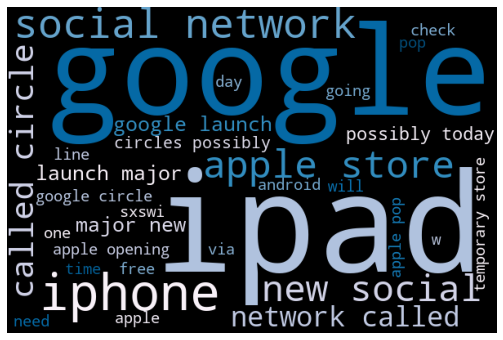

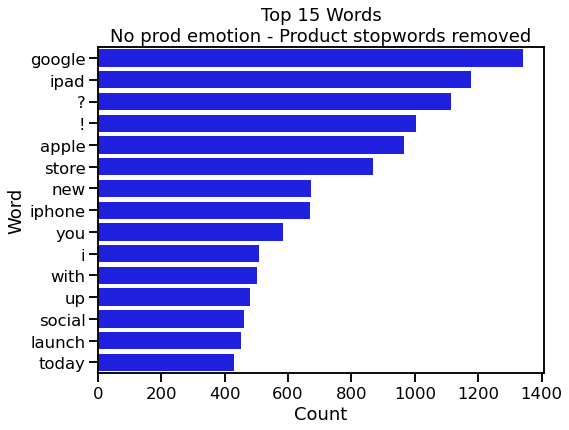

In [62]:
# get frequency distribution for negative emotions
non = FreqDist(token_dict['No emotion toward brand or product'])

non_freq_df = pd.DataFrame(non.most_common(100),
                              columns=['Word','Count'])

generate_wordcloud(docs=token_dict['No emotion toward brand or product'], 
                   cmap="PuBu", 
                   stopwords=None, min_font_size=16)

plot_wordfreqs(non_freq_df, 'Word', 'Count', 15, 
               "No prod emotion - Product stopwords removed")

In the 'No emotion towards a brand or product' class, `major new`, `social network` and `called circle` are top bigrams. A little research turned up that Google+ had a feature called Circles that let you determine who you shared which parts of your feed with, so I suspect at least some of these may be about Google+.

The word `app` is still in the top 15, but in a lower position in the 'No emotion' group than it was in positive and negative. It seems the positive/negative emotions towards brands or products commonly refer to apps.

In [63]:
df.loc[(df['tweet_text'].str.contains("circle")) &
      (df['emotion']=='No emotion toward brand or product'), 
       ['tweet_text']]

,tweet_text
158,Anyone at #sxsw or heading to aclu event seen owt to do with google circles then?
311,"Those who are tweeting that Google is coming out with Circles platform today are outside of the circle, keep up #itsnot #sxsw"
421,Google to debut new selective social network today at #sxsw ? @mention {link} #google #circles
709,.@mention is competing with @mention circles on the SocialFlow board for most resonant topic here. #sxsw {link}
770,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #circles #sxsw"
771,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #google #circles #sxsw"
819,Google to launch social network &quot;Circles&quot; - denies launch at #sxsw though. {link} #google #circles
820,Google to launch social network called circles #sxsw RT
825,Is Google launching its own social network? Definitely not at ##sxsw. But rumor still has it...{link} #googlecircles
1043,ÛÏ@mention RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circlesÛ


I see that most of the tweets mentioning the word `circle` are talking about a rumored launch of Google Circles. Some I would agree are neutral in sentiment, but many seem to be excited about Circles, so I'm wondering why they were not labeled as Positive? An example is row 1644.

## Summary of Exploration

I feel confident about the stopwords and punctuation removal at this point, having a few different versions of lists I can try out to see what works best in modeling.

I see some differences in the most common words between classes, but not a ton. I'm going to have to let the models tell me what else they can glean!

# Export data for gridsearching in Colab

To efficiently gridsearch different parameters for different types of models (including preprocessing steps such as stemming and lemmatization) I exported the cleaned dataframe and stopwords lists I had compiled. This allowed me to run gridsearches in Google Colab in parallel with gridsearching other models on my local machine.

In [64]:
# dump preprocessed df to file, so I can load it up in google colab for
# modeling and gridsearching
joblib.dump(df, f"data/scrubbed_df.joblib.gz")

['data/scrubbed_df.joblib.gz']

In [65]:
# dump current stopwords lists, which will be used in modeling, out to file
stop_lists = {"custom_stopwords": custom_stopwords, 
 "nltk_stopwords": nltk_stopwords, 
 "punc_custom": punc_custom, 
 "product_stopwords": product_stopwords}

for stop in stop_lists.keys():
    joblib.dump(stop_lists[stop], f"data/{stop}.joblib.gz")

# Binary Models for Emotion Only

First, I explored models focused only on the tweets that were labeled as having negative or positive emotions about a product or brand, leaving out the ones labeled as having no emotion towards a product or brand.

I wanted to explore the different options for vectorizing and preprocessing the text on a smaller dataset and with a simpler problem before expanding to a multi-class problem with more data, which will take longer to gridsearch and tune.

This binary classifier will also serve as a baseline for the multi-class problem where I will try to predict Positive, Negative, and No sentiment towards a product or brand. I do want to be able to weed out the tweets which are positive and negative towards a brand from those with no emotion towards a brand, but I'm not sure how well a multi-class model will be able to distinguish between all three. Having looked at the tweets themselves, the distinctions are pretty fine grains, and even I disagree with some of the labels which have been assigned. It might be a better approach to use one model to weed out the tweets which don't have a positive or negative emotion towards a brand, then run the remaining tweets through a second model to separate positive from negative.

A few of the options I'd like to try:

- Different versions of stopwords and punctuation removal. All stopwords from the default NLTK list, which I think may contain some words that will be useful, and then also my customized, pared down stopwords list. I also have the separate product stop words list which contains the terms related to the brands and products themselves, which I want to experiment with removing.


- A few different ways to vectorize and generate the frequencies in my Document Term Matrix. Regular `CountVectorizer` with the actual counts, TFIdF normalized frequencies, and also a binary frequency. The [sklearn documentation mentions](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):
>"...very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable."


- Unigrams, uni- and bigrams, and just bigrams.

Some initial constants:

- I've decided to use just one set of punctuation to be removed, where I will remove everything except `?`, `!`, and `...`.

- I will experiment stemming and lemmatization, but will start without them first.

 
I'll use the `TweetTokenizer` from NLTK to perform the tokenization, since it has the option to remove handled, which I would like to do. To enable experimenting with stemming and lemmatization in a gridsearch, I'll create a custom function which uses the TweetTokenizer, and pass to the `tokenizer` step of the sklearn `CountVectorizer` so I can change it up.

## Preprocessing for binary modeling

In [66]:
# check to make sure the text is still aligned in the columns properly
df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion']), 
           ['tweet_text', 'cleaned', 'emotion']]

,tweet_text,cleaned,emotion
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW","@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)","@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",Positive emotion
...,...,...,...
9049,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,Positive emotion
9051,&quot;papyrus...sort of like the ipad&quot; - nice! Lol! #SXSW Lavelle,"""papyrus...sort of like the ipad"" - nice! Lol! #SXSW Lavelle",Positive emotion
9052,"Diller says Google TV &quot;might be run over by the PlayStation and the Xbox, which are essentially ready today.&quot; #sxsw #diller","Diller says Google TV ""might be run over by the PlayStation and the Xbox, which are essentially ready today."" #sxsw #diller",Negative emotion
9057,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,Positive emotion


In [67]:
df['emotion'].value_counts()

No emotion toward brand or product    5372
Positive emotion                      2968
Negative emotion                       569
I can't tell                           156
Name: emotion, dtype: int64

In [307]:
# create X and y based on just the positive and negative emotions
X = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion']), 
           'cleaned']
y = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion']), 
           'emotion']

In [308]:
X.tail()

9049                                             @mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess
9051                                                                                 "papyrus...sort of like the ipad" - nice! Lol! #SXSW Lavelle
9052                  Diller says Google TV "might be run over by the PlayStation and the Xbox, which are essentially ready today." #sxsw #diller
9057    I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi
9060                                                                                                                Ipad everywhere. #SXSW {link}
Name: cleaned, dtype: object

In [309]:
# generate dicts to transform the labels to ints and back
binary_strkey = {"Negative emotion":1, "Positive emotion": 0}
binary_intkey = {1:"Negative emotion", 0:"Positive emotion"}

# convert class labels to binary
y = y.map(lambda x: binary_strkey[x])
y.value_counts()

0    2968
1     569
Name: emotion, dtype: int64

In [71]:
# Save label translation for later: 1 is negative, 0 is positive
class_labels = ['Positive', 'Negative']

In [205]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                               stratify=y)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

2829
2829
708
708


In [206]:
print(X_train.shape)
print(y_train.shape)

(2829,)
(2829,)


In [207]:
y_train.value_counts(normalize=True)

0    0.839166
1    0.160834
Name: emotion, dtype: float64

In [208]:
y_test.value_counts(normalize=True)

0    0.838983
1    0.161017
Name: emotion, dtype: float64

In [209]:
def eval_clf_model(clf, X_test, y_test, X_train, y_train, score='macro',
               reports=True, labels=['Class 0', 'Class 1'], 
               normalize_cm='true'):
    """Shows metrics and plots visualizations to interpret classifier model 
    performance.
    
    ***
    Args
    
    clf: classifier model to evaluate (or fit pipeline with a clf model as
    the last step)
    
    X_test: dataframe of test predictors
    
    y_test: dataframe of true target values
    
    X_train: dataframe (optional). Default is None. Provide training data if
    you want to evaluate performance on train versus test; otherwise only 
    test performance is evaluated.
    
    y_train: dataframe (optional). Default is None. Provide training data if
    you want to evaluate performance on train versus test; otherwise only 
    test performance is evaluated.
    
    score: string (optional). Default is `std` to return standard F1, accuracy, 
    and recall scores. Use `macro` to return macro F1 and recall, and balanced
    accuracy. Scores are always returned, regardles of `reports` param.
    
    reports: boolean (optional). Default is True. Set to False to return only 
    scores, not actual classification reports.
    
    labels: list (optional). Provide a list of labels for the target class.
    
    normalize_cm: string, default `true`. Setting for whether and how to
    normalize the confusion matrix. See sklearn documentation for options.
    """
    multi = True if len(labels) > 2 else False
    
    spacer = '*'*30
    
    # Get predictions 1 time only, since they will be used in a few spots
    test_preds = clf.predict(X_test)
    train_preds = clf.predict(X_train)
    
    #if multi:
    #    test_predict_proba = clf.predict_proba(X_test)
    
    # print classification reports
    if reports:
        print(spacer + ' Training Data ' + spacer)
        print(metrics.classification_report(y_train, train_preds))
        print()
        print(spacer + ' Test Data ' + spacer)
        print(metrics.classification_report(y_test, test_preds))
        print()
    
    # print scores from train and test next to each other for easy comparison
    print(spacer + ' Training Scores ' + spacer)

    # Train
    if score == 'std':
        train_f1 = np.round(metrics.f1_score(y_train, train_preds), 4)
        print(f"                  Training F1 = {train_f1}")
        train_r = np.round(metrics.recall_score(y_train, train_preds), 4)
        print(f"              Training Recall = {train_r}")
        train_acc = np.round(metrics.accuracy_score(y_train, train_preds), 4)
        print(f"            Training Accuracy = {train_acc}")
    elif score == 'macro':
        train_f1m = np.round(metrics.f1_score(y_train, train_preds, average='macro'), 4)
        print(f"            Training Macro F1 = {train_f1m}")
        train_rm = np.round(metrics.recall_score(y_train, train_preds, average='macro'), 4)
        print(f"        Training Macro Recall = {train_rm}")
        train_accbal = np.round(metrics.balanced_accuracy_score(y_train, train_preds), 4)
        print(f"   Training Balanced Accuracy = {train_accbal}")
    print()
    print(spacer + ' Test Scores ' + spacer)
    
    #Test
    if score == 'std':
        test_f1 = np.round(metrics.f1_score(y_test, test_preds), 4)
        print(f"                      Test F1 = {test_f1}")
        test_r = np.round(metrics.recall_score(y_test, test_preds), 4)
        print(f"                  Test Recall = {test_r}")
        test_acc = np.round(metrics.accuracy_score(y_test, test_preds), 4)
        print(f"                Test Accuracy = {test_acc}")
        
    elif score == 'macro':
        test_f1m = np.round(metrics.f1_score(y_test, test_preds, average='macro'), 4)
        print(f"                Test Macro F1 = {test_f1m}")
        test_rm = np.round(metrics.recall_score(y_test, test_preds, average='macro'), 4)
        print(f"            Test Macro Recall = {test_rm}")
        test_accbal = np.round(metrics.balanced_accuracy_score(y_test, test_preds), 4)
        print(f"       Test Balanced Accuracy = {test_accbal}")
    print()
    print(spacer + ' Differences ' + spacer)
    
    #Diffs
    if score == 'std':
        print(f"               Train-Test F1 Diff = {test_f1 - train_f1}")       
        print(f"           Train-Test Recall Diff = {test_r - train_r}")       
        print(f"         Train-Test Accuracy Diff = {test_acc - train_acc}")     
    elif score == 'macro':  
        print(f"         Train-Test Macro F1 Diff = {test_f1m - train_f1m}")      
        print(f"     Train-Test Macro Recall Diff = {test_rm - train_rm}")       
        print(f"Train-Test Balanced Accuracy Diff = {test_accbal - train_accbal}")
    
    print()
    print(spacer + ' Graphs for Test ' + spacer)
    
    # plot graphs
    
    if not multi:
        auc = np.round(metrics.roc_auc_score(y_test, test_preds), 2)
        
        ap = np.round(metrics.average_precision_score(y_test, test_preds), 2)

        fig, [ax1, ax2, ax3] = plt.subplots(figsize=[10, 3], nrows=1, ncols=3)
        plt.tight_layout(pad=2.5)
        metrics.plot_confusion_matrix(clf, X_test, y_test, 
                normalize=normalize_cm, display_labels=labels, 
                                      cmap='Reds', ax=ax1)
        metrics.plot_roc_curve(clf, X_test, y_test, ax=ax2)
        ax2.legend(loc='best', fontsize='small', labels=[f'AUC: {auc}'])

        metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax3)
        ax3.legend(loc='best', fontsize='small')
        ax3.legend(loc='best', fontsize='small', labels=[f'AP: {ap}'])
        plt.show();
    
    #if multi-class, just plot confusion matrix
    else:
        fig, ax1 = plt.subplots(figsize=[6, 4])
        plt.tight_layout(pad=2.5)
        metrics.plot_confusion_matrix(clf, X_test, y_test, 
                normalize=normalize_cm, display_labels=labels, cmap='Reds', 
                                      ax=ax1)
        plt.show();
        
    
    return None

In [210]:
# Path I'm going to use to save best estimators from gridsearching
save_path = "models/"

In [211]:
def clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                     class_labels, file_name, save_path, 
                     scoring='recall_macro', n_jobs=-1, verbose=True,
                     normalize_cm='true'):
    """
    Uses provided `clf_pipe` and `grid_params` to perform a GridSearchCV on best
    params according to specified `scoring` metric. See sklearn documentation 
    for available scoring metrics.
    
    Once best estimator is found, both the best estimator and the entire 
    GridSearchCV object are dumped to file using joblib. `file_name` and 
    `save_path` used in this exporting to file.
    
    normalize_cm: string, default `true`. Setting for whether and how to
    normalize the confusion matrix. See sklearn documentation for options.
    """
    gs = GridSearchCV(clf_pipe, grid_params, n_jobs=n_jobs, verbose=verbose,
                         scoring=scoring)

    # run the gridsearch
    gs.fit(X_train, y_train)

    # print best estimator params and score
    print(gs.best_estimator_)
    print(gs.best_score_)

    # dump out best estimator and gs object to gdrive
    joblib.dump(gs.best_estimator_.named_steps['clf'], 
                f"{save_path}BestEst_{file_name}.joblib.gz")
    print()
    print(f"Saved best estimator to: {save_path}BestEst_{file_name}.joblib.gz")
    joblib.dump(gs, f"{save_path}GSObject_{file_name}.joblib.gz")
    print()
    print(f"Saved GridSearch object to: {save_path}GSObject_{file_name}.joblib.gz")

    # print the classifier model report
    eval_clf_model(gs, X_test, y_test, X_train, y_train, labels=class_labels,
                  normalize_cm=normalize_cm)

    return None

## Build modeling pipeline

In [212]:
# Will use TweetTokenizer with strip_handles=True to tokenize and lowercase
# for now, we're not going to be doing any stemming or lemmatization,
# so I'll just use the class as-is
tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

# pre-processing pipeline to transform into vectors
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])


## Baseline Dummy Classifier

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2374
           1       0.15      0.15      0.15       455

    accuracy                           0.73      2829
   macro avg       0.49      0.49      0.49      2829
weighted avg       0.73      0.73      0.73      2829


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       594
           1       0.19      0.16      0.17       114

    accuracy                           0.76       708
   macro avg       0.52      0.51      0.51       708
weighted avg       0.74      0.76      0.75       708


****************************** Training Scores ******************************
            Training Macro F1 = 0.4947
        Training Macro Recall = 0.4948
   Training Balanced Accuracy = 0.4948



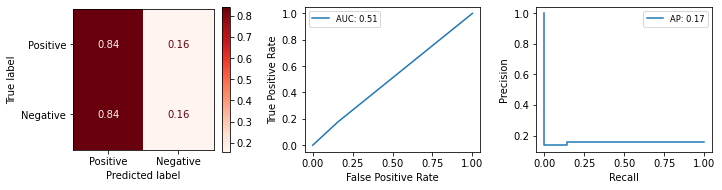

In [213]:
# Let's make a baseline classifier using the dummy model
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', DummyClassifier(strategy='stratified'))
])

clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, 
               labels=class_labels)

##  Testing Freq Options on Multinomial Bayes Models

I'm going to run a few models using a Multinomial Bayes classifier, with minimal processing.

All of the models below are using the preprocessed documents (non-ASCII characters and numbers removed), with Twitter handles removed and lowercasing performed by the TweetTokenizer. 

I'm not removing stopwords or punctuation yet for these baseline models.

I'm also not experimenting with different sizes of n-grams.

The main thing I do want to try to determine is which method of calculating the Document Term Matrix is best for this text. 
Regular `CountVectorizer` with the raw counts, binary count, or TF-IDF normalized. The [sklearn documentation mentions](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction):
>"...very short texts are likely to have noisy tf–idf values while the binary occurrence info is more stable."

Rather than gridsearch through the different types of vectorizers, which will x3 my computational load and time, I'd prefer to settle on one of these vectorizing options up front and use gridsearch for other parameters and processing options such as n-grams and which stop-words to remove.

In [214]:
# modling pipeline with preprocessing and model built in
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', MultinomialNB())
])

### Tfidf Standardized Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2374
           1       1.00      0.05      0.10       455

    accuracy                           0.85      2829
   macro avg       0.92      0.53      0.51      2829
weighted avg       0.87      0.85      0.79      2829


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       594
           1       1.00      0.02      0.03       114

    accuracy                           0.84       708
   macro avg       0.92      0.51      0.47       708
weighted avg       0.87      0.84      0.77       708


****************************** Training Scores ******************************
            Training Macro F1 = 0.5085
        Training Macro Recall = 0.5264
   Training Balanced Accuracy = 0.5264



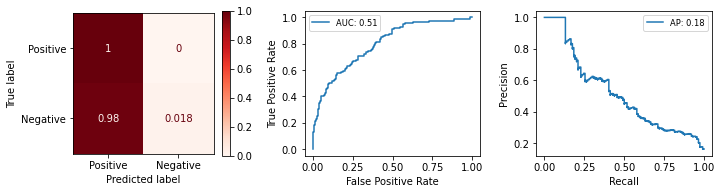

In [215]:
clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, labels=class_labels)

These results are actually worse than the dummy classifier; it's just predicting positive for almost everything.

### Counted Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2374
           1       0.91      0.73      0.81       455

    accuracy                           0.94      2829
   macro avg       0.93      0.86      0.89      2829
weighted avg       0.94      0.94      0.94      2829


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       594
           1       0.72      0.25      0.38       114

    accuracy                           0.86       708
   macro avg       0.80      0.62      0.65       708
weighted avg       0.85      0.86      0.84       708


****************************** Training Scores ******************************
            Training Macro F1 = 0.8873
        Training Macro Recall = 0.8566
   Training Balanced Accuracy = 0.8566



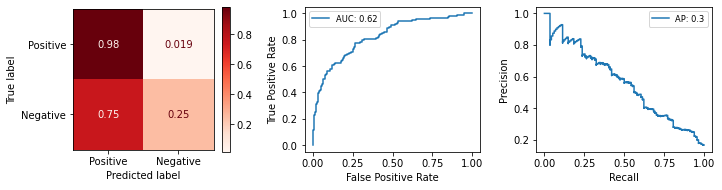

In [216]:
# Since my pipeline includes the Tfidf transformer, I'm explicitly setting
# that pipeline step to be passthrough here to remove it
clf_pipe.set_params(prep__vect__binary=False)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, labels=class_labels)

Better than Tfidf, but still not great on test, with only 32% recall on my target class of Negative.

It's also looking pretty overfit to the training data.

### Binary Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      2374
           1       0.92      0.73      0.81       455

    accuracy                           0.95      2829
   macro avg       0.94      0.86      0.89      2829
weighted avg       0.95      0.95      0.94      2829


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       594
           1       0.79      0.27      0.41       114

    accuracy                           0.87       708
   macro avg       0.84      0.63      0.67       708
weighted avg       0.86      0.87      0.84       708


****************************** Training Scores ******************************
            Training Macro F1 = 0.8918
        Training Macro Recall = 0.8589
   Training Balanced Accuracy = 0.8589



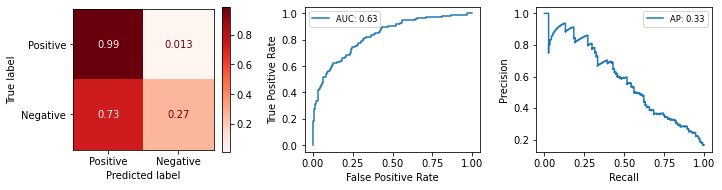

In [217]:
# Let's try the binary representation instead of raw counts
clf_pipe.set_params(prep__vect__binary=True)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(X_train, y_train)

eval_clf_model(clf_pipe, X_test, y_test, X_train, y_train, labels=class_labels)

So testing out the different ways I could calculate frequency in the document term matrix, Tfidf performed the poorest on this test where I've done minimal processing (no stopwords or punctuation removal, for instance).

The performance difference between binary and count isn't much.

Initially, I excluded Tfidf frequency from my modeling based on this test without stopwords and punctuation removed. However, when I tried including it in a model with tuned parameters, including removing stopwords and punctuation, it actually performed better in some cases. I revised my approach, and went back and added Tfidf transformation as a step in gridsearching along with other parameters. Although Tfidf performed the worst on minimally processed documents, it sometimes worked better in conjunction with other preprocessing steps and model parameters.

## GridSearchCVs: no stemming or lemmatization

First, I'm going to search through params without applying any stemming or lemmatization, but removing stop words and punctuation.

In [218]:
# set this variable equal to True to re-run the gridsearches
rerun_grid = False

I used this same set of vectorization and preprocessing parameters to gridsearch all of the models, changing only the model-specific params, and updating the tokenizer to include stemming and lemmatization or not.

I initially tried to let the best preprocessing params from one gridsearch inform what should be included/excluded in other gridsearches that used different classifiers. However, upon further testing, I found this was not a sound approach, and decided to do an exhaustive gridsearch for each classifier and modeling scenario.

In [219]:
# Params that will apply to the vectorizer regardless of how the
# document term matrix is constructed
common_params = {"vect__stop_words": [custom_stopwords + punc_custom,
            nltk_stopwords + punc_custom,
            product_stopwords + custom_stopwords + punc_custom,
            punc_custom + product_stopwords + nltk_stopwords],
    "vect__ngram_range": [(1,1), (1,2), (2,2)],
    "vect__max_features": [None, 1000]}

# Params for the binary frequency, where we don't want to bother with a Tfidf
binary_params = {
    "vect__binary": [True],
    "trans": ['passthrough']}

# params for non-binary frequency, where we want to test both with and without
# Tfidf
count_params = {
    "vect__binary": [False],
    "trans": [TfidfTransformer(), 'passthrough']}

### Multinomial Bayes

In [220]:
if rerun_grid:
    # Add Multinomial Bayes as the classifier model
    clf_pipe = Pipeline([
        ('prep', prep_pipe),
        ('clf', MultinomialNB())
    ])

    # classifier-specific params for MNB
    clf_params = {"clf__fit_prior": [True, False]}

    # create grid params for MNB
    grid_params = [{**common_params, **binary_params, **clf_params},
                   {**common_params, **count_params, **clf_params}]

    model_name = "MNB_binary_nostemlem"

    # gridsearch MNB
    clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                         class_labels, file_name=model_name, save_path=save_path, 
                         scoring='recall_macro')

The gridsearch above was actually executed in Google Colab, from which I exported the best estimator and GS object to file. I'll load back in here to show the results.

Since colab is running a slightly different version of python, I'll load in the best estimator and then create a new pipeline using the best params. This will also make sure that I'm re-fitting the model to the current train split.

In [221]:
def load_rebuild_eval_bestpipe(gsfile_name, X_train, y_train, X_test, y_test, 
                              class_labels, load_path=''):
    """
    Loads and rebuilds the best pipeline (including estimator) from a 
    GridSearch object that was dumped to file using `joblib`. Fits on
    X_train and y_train, and runs classifier evaluation function to show
    model performance.
    
    Returns new pipeline object built using the best params from the gridsearch,
    and the gridsearch object itself, so it can be queried to show its best
    score.
    
    `load_path` should be the path to the gridsearch file to load in, if not
    in current directory.
    """
    
    gs = joblib.load(load_path + gsfile_name)
    
    pipe = Pipeline(gs.best_estimator_.get_params()['steps'])
    
    print(gs.best_estimator_.get_params()['steps'])
    print()
    print(f"Best score from GS-CV: {np.round(gs.best_score_, 3)}")
    print()

    pipe.fit(X_train, y_train)

    eval_clf_model(pipe, X_test, y_test, X_train, y_train, 
                   labels=class_labels)
    
    return pipe, gs

/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: U

[('prep', Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, max_features=1000,
                                 stop_words=['google', 'apple', 'ipad',
                                             'iphone', 'android', 'ipad2',
                                             '#google', '#apple', '#ipad',
                                             '#iphone', '#android', '#ipad2',
                                             'a', 'an', 'and', 'am', 'are',
                                             'as', 'at', 'be', 'by', 'for',
                                             'from', 'if', 'in', 'is', 'into',
                                             'it', "it's", 'its', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd1970b0df0>>)),
                ('trans', 'passthrough')])), ('clf', MultinomialNB(fit_prior=False))]

Best score from GS-CV: 0.757

*****************************

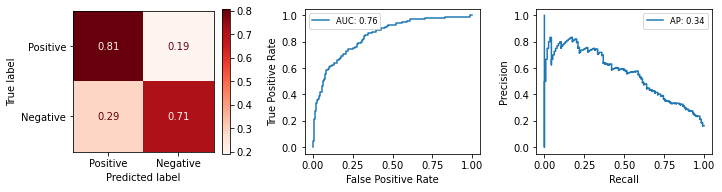

In [222]:
# load and eval pipeline with best params from colab gridsearch
best_MNB_binary_nostemlem_pipe, best_MNB_binary_nostemlem_gs = \
load_rebuild_eval_bestpipe('GSObject_MNB_binary_nostemlem.joblib.gz', 
                           X_train, y_train, X_test, y_test, 
                           class_labels, load_path=save_path)

Yeah, that looks much more similar to the results in the colab environment. I think I can trust the best params from the colab gridsearch, but need to rebuild and fit the estimator to actually evaluate performance and coefficients.

### Random Forest

In [223]:
if rerun_grid:
    # Subbing Random Forest for the classifier
    clf_pipe = Pipeline([
        ('prep', prep_pipe),
        ('clf', RandomForestClassifier(class_weight='balanced'))
    ])

    # classifier-specific params for RF
    clf_params = {"clf__criterion": ['gini', 'entropy'],
        "clf__max_depth": [5, 10, 50]}

    # create grid params for RF
    grid_params = [{**common_params, **binary_params, **clf_params},
                   {**common_params, **count_params, **clf_params}]

    model_name = "RF_binary_nostemlem"

    # run gridsearch for RF
    clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                         class_labels, file_name=model_name, save_path=save_path, 
                         scoring='recall_macro')

/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: U

[('prep', Pipeline(steps=[('vect',
                 CountVectorizer(binary=True, max_features=1000,
                                 stop_words=['a', 'an', 'and', 'am', 'are',
                                             'as', 'at', 'be', 'by', 'for',
                                             'from', 'if', 'in', 'is', 'into',
                                             'it', "it's", 'its', 'itself',
                                             'of', 'on', 'or', 'than', 'that',
                                             'the', 'to', 'austin', 'sxsw',
                                             '#sxsw', 'link', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd1980c4eb0>>)),
                ('trans', 'passthrough')])), ('clf', RandomForestClassifier(class_weight='balanced', max_depth=5))]

Best score from GS-CV: 0.723

****************************** Training Data ***************************

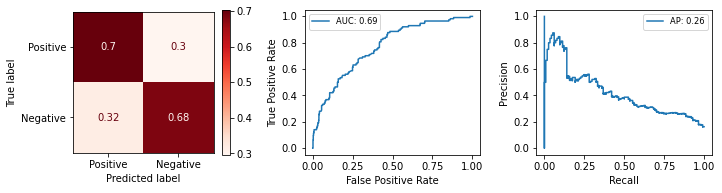

In [224]:
# load and eval pipeline with best params from colab gridsearch
best_RF_binary_nostemlem_pipe, best_RF_binary_nostemlem_gs = \
load_rebuild_eval_bestpipe('GSObject_RF_binary_nostemlem.joblib.gz', 
                           X_train, y_train, X_test, y_test, 
                           class_labels, load_path=save_path)

### Logistic Regression

In [225]:
if rerun_grid:
    # Subbing Logistic Regression for the classifier
    clf_pipe = Pipeline([
        ('prep', prep_pipe),
        ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
    ])

    # classifier-specific params for LR
    clf_params = {"clf__penalty": ['l1', 'l2', 'elasticnet'],
        "clf__fit_intercept": [True, False],
        "clf__solver": ['newton-cg', 'lbfgs', 'saga'],
        "clf__C": [1, 0.1]}

    # create grid params for LR
    grid_params = [{**common_params, **binary_params, **clf_params},
                   {**common_params, **count_params, **clf_params}]

    model_name = "LR_binary_nostemlem"

    # run gridsearch for LR
    clf_gridsearch_wpipe(clf_pipe, grid_params, X_train, y_train, X_test, y_test,
                         class_labels, file_name=model_name, save_path=save_path, 
                         scoring='recall_macro')

/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: U

[('prep', Pipeline(steps=[('vect',
                 CountVectorizer(stop_words=['a', 'an', 'and', 'am', 'are',
                                             'as', 'at', 'be', 'by', 'for',
                                             'from', 'if', 'in', 'is', 'into',
                                             'it', "it's", 'its', 'itself',
                                             'of', 'on', 'or', 'than', 'that',
                                             'the', 'to', 'austin', 'sxsw',
                                             '#sxsw', 'link', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd1b09d4df0>>)),
                ('trans', TfidfTransformer())])), ('clf', LogisticRegression(C=1, class_weight='balanced', fit_intercept=False,
                   max_iter=500, solver='newton-cg'))]

Best score from GS-CV: 0.76

****************************** Training Data **************************

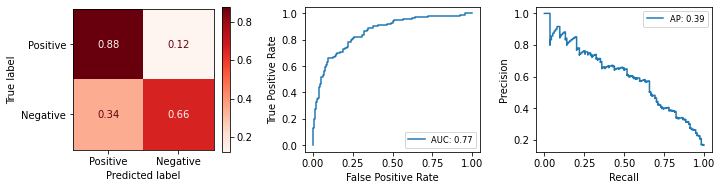

In [226]:
# load and eval pipeline with best params from colab gridsearch
best_LR_binary_nostemlem_pipe, best_LR_binary_nostemlem_gs = \
load_rebuild_eval_bestpipe('GSObject_LR_binary_nostemlem.joblib.gz', 
                           X_train, y_train, X_test, y_test, 
                           class_labels, load_path=save_path)

Looking at the best model from each of these, I'm seeing that they're all pretty overfit to the training data, with a difference of 8-12% on macro F1 and macro recall between train and test on most.

Since I'm optimizing for `recall_macro`, this is balancing the recall for both the positive and negative classes. When I run again using different train-test-splits, I find the balance between recall for positive and negative varies a lot. I've seen as high as 72% for true negative class using these same parameters, although the TTS in this iteration is only 61%.

In [227]:
# what would be the best recall (optimizing for the negative class only)?
xval = cross_val_score(best_LR_binary_nostemlem_pipe, X_train, y_train, 
                       scoring='recall', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


All scores: [0.65934066 0.61538462 0.68131868 0.72527473 0.68131868]
Average x-validated score (recall): 0.673



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.1s finished


## Try out some stemming and lemmatization on the best models

I'm not going to gridsearch again with stemming and lemmatization, I will just test the best model params from gridsearching without stemming and lemmatization, and see if it improves performance.

In [95]:
#nltk.download('wordnet')

In [96]:
stemmer = PorterStemmer()
stemmer.stem('testing')

'test'

In [97]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize("testing")

'testing'

In [98]:
lemmatizer.lemmatize("feet")

'foot'

Hmm, so the lemmatizer is not doing the best job here even with a simple word like `testing`. Stemming did much better with that.

Maybe I'll try passing through lemmatizer first (which will leave words it can't do anything with alone, but change what it can) and then do stemming separately.

In [99]:
def tokenize_lemma_stem(doc):
    """
    Applies TweetTokenization, then lemmatization and stemming in one shot.
    
    Uses NLTK, so assumes the appropriate NLTK classes have been imported.
    
    Uses TweetTokenizer to tokenize documents first, and remove handles.
    Then uses NLTK lemmatization on each token.
    Finally, applies stemming to each token.
    """
    tweettokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    # tokenize using TweetTokenizer
    tokens = tweettokenizer.tokenize(doc)
    
    # lemmatize using NLTK
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # stem using NLTK
    tokens = [stemmer.stem(token, ) for token in tokens]
    
    return tokens

Let's test it out!

In [100]:
tokenize_lemma_stem("This isn't what I was hoping for. I'm testing. Feet and hands. What do you think? Thinking?")

['thi',
 "isn't",
 'what',
 'i',
 'wa',
 'hope',
 'for',
 '.',
 "i'm",
 'test',
 '.',
 'foot',
 'and',
 'hand',
 '.',
 'what',
 'do',
 'you',
 'think',
 '?',
 'think',
 '?']

### Multinomial Bayes

In [101]:
from sklearn.base import clone

# copy the best MNB pipeline/model from the gridsearch (deep copy)
MNB_binary_withstemlem_pipe = clone(best_MNB_binary_nostemlem_pipe)

# set tokenizer in the copy to use the function with stemming and lemmatization
MNB_binary_withstemlem_pipe.set_params(prep__vect__tokenizer=tokenize_lemma_stem)

# check params
MNB_binary_withstemlem_pipe

Pipeline(steps=[('prep',
                 Pipeline(steps=[('vect',
                                  CountVectorizer(binary=True,
                                                  max_features=1000,
                                                  stop_words=['google', 'apple',
                                                              'ipad', 'iphone',
                                                              'android',
                                                              'ipad2',
                                                              '#google',
                                                              '#apple', '#ipad',
                                                              '#iphone',
                                                              '#android',
                                                              '#ipad2', 'a',
                                                              'an', 'and', 'am',
                                     

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.1s finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#appl', '#googl', '#iphon', '2', 'appl', 'googl', 'iphon', "it'"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


All scores: [0.73621747 0.72289184 0.76474263 0.73329092 0.763261  ]
Average x-validated score (recall): 0.744

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      2374
           1       0.48      0.87      0.62       455

    accuracy                           0.83      2829
   macro avg       0.73      0.84      0.75      2829
weighted avg       0.89      0.83      0.85      2829


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.95      0.78      0.85       594
           1       0.40      0.77      0.53       114

    accuracy                           0.78       708
   macro avg       0.67      0.77      0.69       708
weighted avg       0.86      0.78      0.80       708


****************************** Training Scores ******************************
      

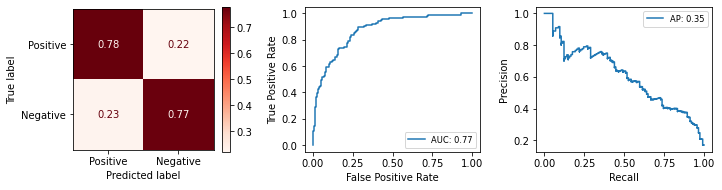

In [102]:
# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(MNB_binary_withstemlem_pipe, X_train, y_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
MNB_binary_withstemlem_pipe.fit(X_train, y_train)

eval_clf_model(MNB_binary_withstemlem_pipe, X_test, y_test, X_train, y_train, 
               labels=class_labels)

Not much different from the cross-validated recall_macro score without stemming and lemmatization. In fact this version is slightly worse.

I ended up running a gridsearch will all the params in colab just to see if a different combination of other parameters could result in better performance using stemming/lemmatization, but it was about the same if not slightly worse.

### Logistic Regression

Best params without stemming/lemmatization, with stemming/lemmatization applied.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    8.8s finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["it'"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


All scores: [0.76720648 0.72722961 0.79270098 0.76101793 0.78796309]
Average x-validated score (recall): 0.767

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2374
           1       0.68      0.98      0.80       455

    accuracy                           0.92      2829
   macro avg       0.84      0.95      0.88      2829
weighted avg       0.95      0.92      0.93      2829


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       594
           1       0.50      0.75      0.60       114

    accuracy                           0.84       708
   macro avg       0.72      0.80      0.75       708
weighted avg       0.87      0.84      0.85       708


****************************** Training Scores ******************************
      

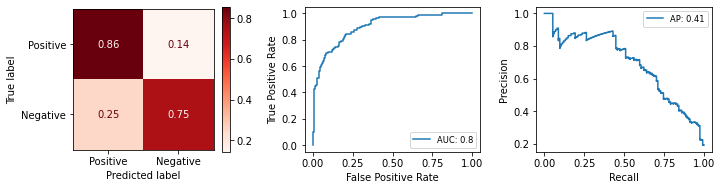

In [103]:
# copy the best MNB pipeline/model from the gridsearch (deep copy)
LR_binary_withstemlem_pipe = clone(best_LR_binary_nostemlem_pipe)

# set tokenizer in the copy to use the function with stemming and lemmatization
LR_binary_withstemlem_pipe.set_params(prep__vect__tokenizer=tokenize_lemma_stem)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(LR_binary_withstemlem_pipe, X_train, y_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
LR_binary_withstemlem_pipe.fit(X_train, y_train)

eval_clf_model(LR_binary_withstemlem_pipe, X_test, y_test, X_train, y_train, 
               labels=class_labels)

### Gridsearch for Logistic Regression

Gridsearch was run in colab, and got different best params with stem/lemma than without.

/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.22.2.post1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/base.py:329: U

[('prep', Pipeline(steps=[('vect',
                 CountVectorizer(max_features=1000,
                                 stop_words=['a', 'an', 'and', 'am', 'are',
                                             'as', 'at', 'be', 'by', 'for',
                                             'from', 'if', 'in', 'is', 'into',
                                             'it', "it's", 'its', 'itself',
                                             'of', 'on', 'or', 'than', 'that',
                                             'the', 'to', 'austin', 'sxsw',
                                             '#sxsw', 'link', ...],
                                 tokenizer=<function tokenize_lemma_stem at 0x7fd1b253c0d0>)),
                ('trans', TfidfTransformer())])), ('clf', LogisticRegression(C=1, class_weight='balanced', max_iter=500, solver='saga'))]

Best score from GS-CV: 0.761

****************************** Training Data ******************************
              precision    recall  f1-score

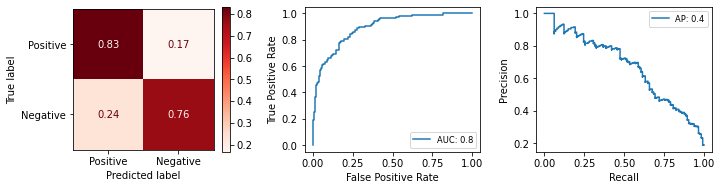

In [104]:
# load and eval pipeline with best params from colab gridsearch
best_LR_binary_withstemlem_pipe, best_LR_binary_withstemlem_gs = \
load_rebuild_eval_bestpipe('GSObject_LR_binary_withstemlem.joblib.gz', 
                           X_train, y_train, X_test, y_test, 
                           class_labels, load_path=save_path)

Although gridsearch specifically including the stem/lemma preprocessing yielded different best params than without stem/lemma, the overall recall_macro score on cross validation is not significantly different, knowing that scores at this point are varying quite a bit depending on the specific makeup of train-test-split.

# Modeling Multi-class

Initially, I built models to parse out the positive or negative product sentiment, to understand what people said that contributed to each one. However, in order to use that model on other/future datasets, we would first need to separate out the tweets that had NO emotion towards products or brands, versus those that had positive or negative emotion.

I'm going to see if I can build a multi-class model that can perform as well at classifying positive and negative as my binary model (as well as classifying no emotion). I suspect this may be difficult to achieve.

The other option is to try to construct a multi-class model that will predict 'no emotion' very accurately, which would allow me to filter those out. Then the remaining 'some emotion' tweets could be fed into the binary model as a second step.

## Preprocessing for multi-class modeling

In [105]:
df['emotion'].value_counts(1)

No emotion toward brand or product    0.592609
Positive emotion                      0.327413
Negative emotion                      0.062769
I can't tell                          0.017209
Name: emotion, dtype: float64

In [310]:
Xm = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion',
                              'No emotion toward brand or product']), 
           'cleaned']
ym = df.loc[df['emotion'].isin(['Positive emotion', 'Negative emotion',
                              'No emotion toward brand or product']), 
           'emotion']

print(len(Xm))
print(len(ym))

8909
8909


In [312]:
# generate dicts to transform the labels to ints and back
multi_strkey = {"Negative emotion": 0, "No emotion toward brand or product": 1,
                "Positive emotion": 2}
multi_intkey = {0 :"Negative emotion", 1 :"No emotion toward brand or product",
                2 :"Positive emotion"}

# convert class labels to integers
ym = ym.map(lambda x: multi_strkey[x])
ym.value_counts()

1    5372
2    2968
0     569
Name: emotion, dtype: int64

In [108]:
# 0 is negative, 1 is none, 2 is positive
mclass_labels = ['Negative', 'None', 'Positive']

In [109]:
# train test split
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2,
                                               stratify=ym)
print(len(Xm_train))
print(len(ym_train))
print(len(Xm_test))
print(len(ym_test))

7127
7127
1782
1782


In [110]:
ym_train.value_counts(normalize=True)

1    0.603059
2    0.333099
0    0.063842
Name: emotion, dtype: float64

In [111]:
ym_test.value_counts(normalize=True)

1    0.602694
2    0.333333
0    0.063973
Name: emotion, dtype: float64

## Dummy Classifier for Multiclass


****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.06      0.06      0.06       455
           1       0.60      0.61      0.61      4298
           2       0.33      0.33      0.33      2374

    accuracy                           0.48      7127
   macro avg       0.33      0.33      0.33      7127
weighted avg       0.48      0.48      0.48      7127


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.04      0.04      0.04       114
           1       0.60      0.61      0.60      1074
           2       0.32      0.31      0.32       594

    accuracy                           0.47      1782
   macro avg       0.32      0.32      0.32      1782
weighted avg       0.47      0.47      0.47      1782


****************************** Training Scores ******************************
          

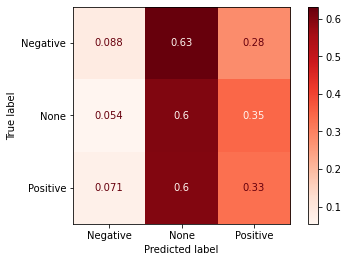

In [112]:
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])

# modling pipeline with preprocessing and model built in
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', DummyClassifier(strategy='stratified'))
])

clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels, normalize_cm='true')

## Baseline Multinomial Bayes Models

In [113]:
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', MultinomialNB())
])

### Tfidf Standardized Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.89      0.02      0.03       455
           1       0.70      0.99      0.82      4298
           2       0.92      0.40      0.56      2374

    accuracy                           0.73      7127
   macro avg       0.84      0.47      0.47      7127
weighted avg       0.79      0.73      0.68      7127


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.64      0.97      0.77      1074
           2       0.74      0.19      0.31       594

    accuracy                           0.65      1782
   macro avg       0.46      0.39      0.36      1782
weighted avg       0.63      0.65      0.57      1782


****************************** Training Scores ******************************
          

/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


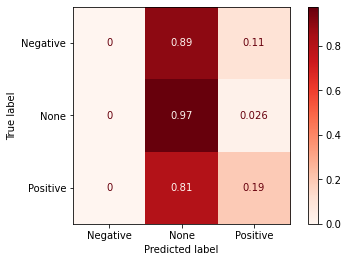

In [114]:
clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

Well that's definitely worse than the dummy; it just pretty much always predicts the 'no emotion' class.

### Counted Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.85      0.43      0.57       455
           1       0.84      0.89      0.86      4298
           2       0.76      0.76      0.76      2374

    accuracy                           0.81      7127
   macro avg       0.82      0.69      0.73      7127
weighted avg       0.81      0.81      0.81      7127


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.57      0.15      0.24       114
           1       0.72      0.78      0.75      1074
           2       0.55      0.54      0.54       594

    accuracy                           0.66      1782
   macro avg       0.61      0.49      0.51      1782
weighted avg       0.65      0.66      0.65      1782


****************************** Training Scores ******************************
          

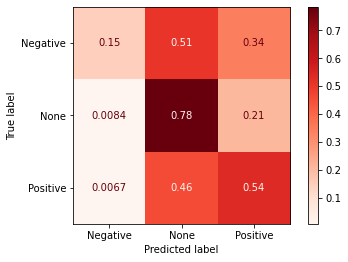

In [115]:
# Since my pipeline includes the Tfidf transformer, I'm explicitly setting
# that pipeline step to be passthrough here to remove it
clf_pipe.set_params(prep__vect__binary=False)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

Not bad on the None class, but we're only classifying 19% of Negatives correctly and 56% of positives correctly.

### Binary Doc Term Matrix

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.86      0.41      0.56       455
           1       0.84      0.90      0.87      4298
           2       0.77      0.75      0.76      2374

    accuracy                           0.82      7127
   macro avg       0.82      0.69      0.73      7127
weighted avg       0.82      0.82      0.81      7127


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.59      0.15      0.24       114
           1       0.72      0.80      0.75      1074
           2       0.56      0.53      0.54       594

    accuracy                           0.67      1782
   macro avg       0.62      0.49      0.51      1782
weighted avg       0.66      0.67      0.65      1782


****************************** Training Scores ******************************
          

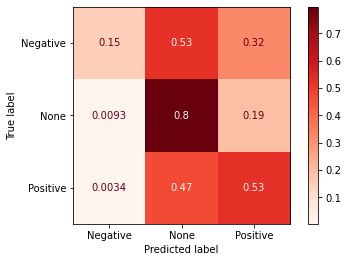

In [116]:
# Let's try the binary representation instead of raw counts
clf_pipe.set_params(prep__vect__binary=True)
clf_pipe.set_params(prep__trans='passthrough')

clf_pipe.fit(Xm_train, ym_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xm_train, ym_train, 
               labels=mclass_labels)

These are all pretty bad. They predict the 'no emotion' class fairly accurately, and where they misclassify they tend to skew towards positive. They're all quite bad at classifying negative emotions.

## GridSearchCVs for best params for various models

In [117]:
# Params that will apply to the vectorizer regardless of how the
# document term matrix is constructed
common_params = {"prep__vect__stop_words": [custom_stopwords + punc_custom,
            nltk_stopwords + punc_custom,
            product_stopwords + custom_stopwords + punc_custom,
            punc_custom + product_stopwords + nltk_stopwords],
    "prep__vect__ngram_range": [(1,1), (1,2), (2,2)],
    "prep__vect__max_features": [None, 1000]}

# Params for the binary frequency, where we don't want to bother with a Tfidf
binary_params = {
    "prep__vect__binary": [True],
    "prep__trans": ['passthrough']}

# params for non-binary frequency, where we want to test both with and without
# Tfidf
count_params = {
    "prep__vect__binary": [False],
    "prep__trans": [TfidfTransformer(), 'passthrough']}

### Multinomial Bayes No stemming

In [118]:
if rerun_grid:
    # pre-processing pipeline with NO stemming or lemmatization
    prep_pipe = Pipeline([
        ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
        ('trans', TfidfTransformer())
    ])

    # main pipeline with clf
    clf_pipe = Pipeline([
        ('prep', prep_pipe),
        ('clf', MultinomialNB())
    ])

    # classifier-specific params for MNB
    clf_params = {"clf__fit_prior": [True, False]}

    # create grid params for MNB
    grid_params = [{**common_params, **binary_params, **clf_params},
                   {**common_params, **count_params, **clf_params}]

    model_name = "MNB_multiclass_nostemlem"

    # run gridsearch for MNB
    clf_gridsearch_wpipe(clf_pipe, grid_params, Xm_train, ym_train, Xm_test, ym_test,
                         mclass_labels, file_name=model_name, save_path=save_path, 
                         scoring='recall_macro')

[('prep', Pipeline(steps=[('vect',
                 CountVectorizer(max_features=1000,
                                 stop_words=['a', 'an', 'and', 'am', 'are',
                                             'as', 'at', 'be', 'by', 'for',
                                             'from', 'if', 'in', 'is', 'into',
                                             'it', "it's", 'its', 'itself',
                                             'of', 'on', 'or', 'than', 'that',
                                             'the', 'to', 'austin', 'sxsw',
                                             '#sxsw', 'link', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd198257310>>)),
                ('trans', 'passthrough')])), ('clf', MultinomialNB(fit_prior=False))]

Best score from GS-CV: 0.565

****************************** Training Data ******************************
              precision    recall  f1-s

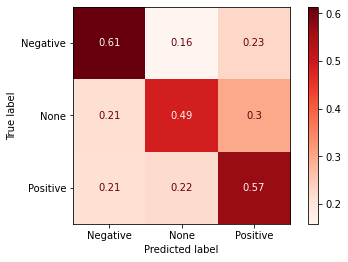

In [119]:
# load and eval pipeline with best params from gridsearch
best_MNB_multiclass_nostemlem_pipe, best_MNB_multiclass_gs = \
load_rebuild_eval_bestpipe('GSObject_MNB_multiclass_nostemlem.joblib.gz', 
                           Xm_train, ym_train, Xm_test, ym_test, 
                           mclass_labels, load_path=save_path)

Not quite as good at predicting negative and positive emotions, based on comparing True Negatives and Positives. But not too bad.

### Multinomial Bayes with Stemming and Lemmatization

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.2s finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["it'"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


All scores: [0.59336158 0.60807399 0.59276507 0.54962313 0.55212512]
Average x-validated score (recall): 0.579

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.24      0.80      0.38       455
           1       0.83      0.56      0.67      4298
           2       0.58      0.67      0.62      2374

    accuracy                           0.61      7127
   macro avg       0.55      0.68      0.56      7127
weighted avg       0.71      0.61      0.64      7127


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.17      0.60      0.27       114
           1       0.77      0.49      0.60      1074
           2       0.48      0.58      0.52       594

    accuracy                           0.52      1782
   macro avg       0.48      0.55      0.46      1782
weighted avg       0.64      0.5

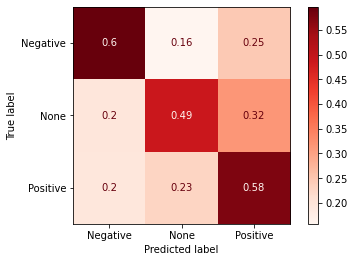

In [120]:
# copy the best MNB pipeline/model from the gridsearch (deep copy)
MNB_multiclass_withstemlem_pipe = clone(best_MNB_multiclass_nostemlem_pipe)

# set tokenizer in the copy to use the function with stemming and lemmatization
MNB_multiclass_withstemlem_pipe.set_params(prep__vect__tokenizer=tokenize_lemma_stem)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(MNB_multiclass_withstemlem_pipe, Xm_train, ym_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
MNB_multiclass_withstemlem_pipe.fit(Xm_train, ym_train)

eval_clf_model(MNB_multiclass_withstemlem_pipe, Xm_test, ym_test, Xm_train, 
               ym_train, labels=mclass_labels)

Stemming/lemmatization doesn't appear to help performance much.

### Logistic Regression No Stemming

In [121]:
if rerun_grid:
    clf_pipe = Pipeline([
        ('prep', prep_pipe),
        ('clf', LogisticRegression(max_iter=500, class_weight='balanced'))
    ])

    # create a dict of params for LR
    clf_params = {"clf__penalty": ['l1', 'l2', 'elasticnet'],
        "clf__fit_intercept": [True, False],
        "clf__solver": ['newton-cg', 'lbfgs', 'saga'],
        "clf__C": [1, 0.1]}

    # create grid params for LR
    grid_params = [{**common_params, **binary_params, **clf_params},
                   {**common_params, **count_params, **clf_params}]

    model_name = "LR_multiclass_nostemlem"

    # run gridsearch for LR
    clf_gridsearch_wpipe(clf_pipe, grid_params, Xm_train, ym_train, Xm_test, ym_test,
                         mclass_labels, file_name=model_name, save_path=save_path, 
                         scoring='recall_macro')

[('prep', Pipeline(steps=[('vect',
                 CountVectorizer(ngram_range=(1, 2),
                                 stop_words=['a', 'an', 'and', 'am', 'are',
                                             'as', 'at', 'be', 'by', 'for',
                                             'from', 'if', 'in', 'is', 'into',
                                             'it', "it's", 'its', 'itself',
                                             'of', 'on', 'or', 'than', 'that',
                                             'the', 'to', 'austin', 'sxsw',
                                             '#sxsw', 'link', ...],
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fd19861fdf0>>)),
                ('trans', TfidfTransformer())])), ('clf', LogisticRegression(C=0.1, class_weight='balanced', max_iter=500,
                   solver='newton-cg'))]

Best score from GS-CV: 0.602

****************************** Train

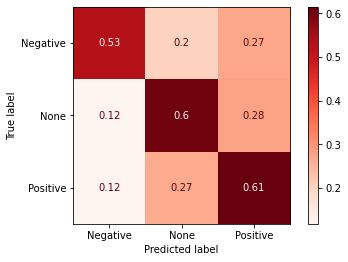

In [122]:
# load and eval pipeline with best params from gridsearch
best_LR_multiclass_nostemlem_pipe, best_LR_multiclass_gs = \
load_rebuild_eval_bestpipe('GSObject_LR_multiclass_nostemlem.joblib.gz', 
                           Xm_train, ym_train, Xm_test, ym_test, 
                           mclass_labels, load_path=save_path)

### Logistic Regression with Stemming and Lemmatization

Let's try the best params from gridsearch with stemming and lemmatization and see if that helps?

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   23.2s finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["it'"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


All scores: [0.62893235 0.65746284 0.62071601 0.59648283 0.57165926]
Average x-validated score (recall): 0.615

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.48      0.95      0.63       455
           1       0.88      0.74      0.81      4298
           2       0.70      0.77      0.73      2374

    accuracy                           0.76      7127
   macro avg       0.69      0.82      0.72      7127
weighted avg       0.79      0.76      0.77      7127


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.24      0.57      0.34       114
           1       0.78      0.60      0.68      1074
           2       0.52      0.60      0.56       594

    accuracy                           0.60      1782
   macro avg       0.51      0.59      0.53      1782
weighted avg       0.66      0.6

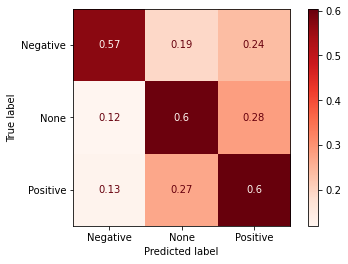

In [123]:
# copy the best LR pipeline/model from the gridsearch (deep copy)
LR_multiclass_withstemlem_pipe = clone(best_LR_multiclass_nostemlem_pipe)

# set tokenizer in the copy to use the function with stemming and lemmatization
LR_multiclass_withstemlem_pipe.set_params(prep__vect__tokenizer=tokenize_lemma_stem)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(LR_multiclass_withstemlem_pipe, Xm_train, ym_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
LR_multiclass_withstemlem_pipe.fit(Xm_train, ym_train)

eval_clf_model(LR_multiclass_withstemlem_pipe, Xm_test, ym_test, Xm_train, 
               ym_train, labels=mclass_labels)

# Imbalanced Classes - Oversampling

I'm seeing that the cross-validated scores are typically pretty close to my test scores across the board, but train scores are 10-20% higher. 

My first impression was that the models were overfit to the training data. However, since cross-validated scores are close to test, I don't think that's the case.

I also considered that the issue could be related to the very imbalanced classes. For Random Forest and Logistic Regression models I used the `class_weight='balanced` hyperparameter, but perhaps that's not addressing all the issues class imbalance can present.

I realized after doing some research and thinking about the problem that the issue may very well be related to the ngrams the models are focusing on being rare enough that they may occur only in train and not in test. Similarly, even when running cross-validation, this may occur if certain ngrams are present in the k-1 training folds but not in the validation fold, which explains why cross-validated scores would match text scores.

The vocabulary used to predict test is based on what it saw in train, so if a lot of the ngrams that predict sentiment occurred only in test and didn't appear in train (or vice versa), we would see consistently lower scores in test because the trained model's vocabulary only includes what it saw. Since people may use synonyms for the same ideas and concepts, and repeated actual words may be rare, no matter how many ways I run a train-test split, there may always be SOME ngrams that are not evenly distributed across training and test. 

With more examples, especially more negative examples to naturally balance out the classes, this  would hopefully be less of a problem.

However, the only way to address this particular problem with the dataset I currently have would be to perform oversampling BEFORE train-test-split, which would not be appropriate since we could potentially include a copy of the same tweet in both train and test and there would be data leakage. Without more labeled data in the same vein, I don't think I can overcome this.

I'm going to use Random Oversampling on the training set anyway, to see whether that improves performance. Even if I don't think it will reduce overfitting, if my cross-validation performance gets closer to my solo train performance, it will support my hypothesis as to the cause of the difference between cross-val and training in previous models.

## Preprocessing for binary ROS

In [124]:
from imblearn.over_sampling import RandomOverSampler

I'm using the same X_train and y_train splits from prior preprocessing, just resampling them. This way, the models trained on oversampled data should be directly comparable to models on non-resampled data.

In [249]:
ros = RandomOverSampler()
Xros_train, yros_train = ros.fit_resample(pd.DataFrame(X_train, 
                                    columns=['cleaned']), y_train)

In [250]:
yros_train.value_counts()

1    2374
0    2374
Name: emotion, dtype: int64

In [251]:
print(len(Xros_train))
print(len(yros_train))

4748
4748


In [252]:
print(Xros_train.shape)
print(yros_train.shape)

(4748, 1)
(4748,)


In [253]:
Xros_train = pd.Series(data=Xros_train['cleaned'])
Xros_train.shape

(4748,)

## ROS - Dummy Classifier

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      2374
           1       0.50      0.50      0.50      2374

    accuracy                           0.50      4748
   macro avg       0.50      0.50      0.50      4748
weighted avg       0.50      0.50      0.50      4748


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.84      0.51      0.64       594
           1       0.17      0.51      0.25       114

    accuracy                           0.51       708
   macro avg       0.51      0.51      0.44       708
weighted avg       0.74      0.51      0.58       708


****************************** Training Scores ******************************
            Training Macro F1 = 0.504
        Training Macro Recall = 0.504
   Training Balanced Accuracy = 0.504

***

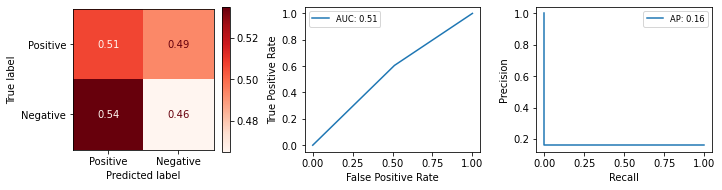

In [254]:
# pre-processing pipeline to transform into vectors
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])

# Let's make a baseline classifier using the dummy model
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', DummyClassifier(strategy='stratified'))
])

clf_pipe.fit(Xros_train, yros_train)

eval_clf_model(clf_pipe, X_test, y_test, Xros_train, yros_train, 
               labels=class_labels)

## ROS - LR no stemming/lemmas

I'm going to focus on Logistic Regression models, since they performed the best in terms of cross-validated recall scores. I don't have the resources to redo a full gridsearch, so I'll use the same best parameters we got from gridsearching unsampled data.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.8s finished


All scores: [0.90421053 0.91578947 0.89578947 0.92206529 0.91880746]
Average x-validated score (recall): 0.911

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2374
           1       0.95      0.98      0.96      2374

    accuracy                           0.96      4748
   macro avg       0.96      0.96      0.96      4748
weighted avg       0.96      0.96      0.96      4748


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       594
           1       0.54      0.61      0.57       114

    accuracy                           0.85       708
   macro avg       0.73      0.75      0.74       708
weighted avg       0.86      0.85      0.86       708


****************************** Training Scores ******************************
      

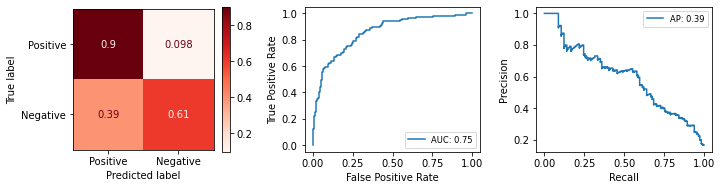

In [255]:
# copy the best LR pipeline/model from the gridsearch (deep copy)
ros_LR_binary_nostemlem_pipe = clone(best_LR_binary_nostemlem_pipe)

# get cross_val_scores for best LR model with stemming/lemmatization
xval = cross_val_score(ros_LR_binary_nostemlem_pipe, Xros_train, yros_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
ros_LR_binary_nostemlem_pipe.fit(Xros_train, yros_train)

eval_clf_model(ros_LR_binary_nostemlem_pipe, X_test, y_test, Xros_train, 
               yros_train, labels=class_labels, normalize_cm='true')

Cross-validated score is much closer to train score, so I think this supports my hypothesis about the class imbalance and randomness of splits.

I've tried these models out on various train-test splits and gotten varied results on test. The oversampling here though was done on the same X_train and y_train splits I used for the non-resampled data, so I can compare the test results directly.

The oversampled training data results in a higher percentage of Positive tweets being identified correctly, but a lower percentage of Negatives. I'm operating on the assumption that companies would want to balance identifying both Positive and Negative sentiments, to understand both what the public likes and doesn't like about their brand and products. The original non-resampled performance has a better balance between the classes, so I actually think it's the better model for this purpose.

That said, I'll compare this approach using stemming/lemmatization, and also on the multi-class problem, so see if any of the models trained on oversampled data perform better.

Try with `min_df=2`? I read that removing words with low frequencies could help with overfitting.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.8s finished


All scores: [0.90210526 0.92       0.89473684 0.92416611 0.9219809 ]
Average x-validated score (recall): 0.913

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      2374
           1       0.95      0.98      0.96      2374

    accuracy                           0.96      4748
   macro avg       0.96      0.96      0.96      4748
weighted avg       0.96      0.96      0.96      4748


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       594
           1       0.58      0.60      0.59       114

    accuracy                           0.86       708
   macro avg       0.75      0.76      0.75       708
weighted avg       0.87      0.86      0.87       708


****************************** Training Scores ******************************
      

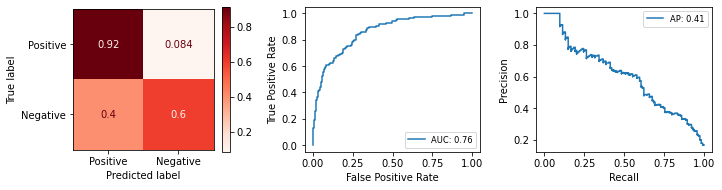

In [256]:
# copy the best LR pipeline/model from the gridsearch (deep copy)
ros_LR_binary_min_nostemlem_pipe = clone(best_LR_binary_nostemlem_pipe)

# try setting min_df=2 (default is 1) to remove tokens with freq 2 or less
# perhaps it will overfit less?
ros_LR_binary_min_nostemlem_pipe.set_params(prep__vect__min_df=2)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(ros_LR_binary_min_nostemlem_pipe, Xros_train, yros_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
ros_LR_binary_min_nostemlem_pipe.fit(Xros_train, yros_train)

eval_clf_model(ros_LR_binary_min_nostemlem_pipe, X_test, y_test, Xros_train, 
               yros_train, labels=class_labels, normalize_cm='true')

No, I tried a few different values (0, 2, 5) and none made much difference, except that 5 made performance on Negative class worse.

## ROS - LR with stemming/lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   15.7s finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["it'"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


All scores: [0.90315789 0.91894737 0.89578947 0.91364202 0.90721963]
Average x-validated score (recall): 0.908

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      2374
           1       0.94      0.98      0.96      2374

    accuracy                           0.96      4748
   macro avg       0.96      0.96      0.96      4748
weighted avg       0.96      0.96      0.96      4748


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       594
           1       0.53      0.59      0.56       114

    accuracy                           0.85       708
   macro avg       0.72      0.74      0.73       708
weighted avg       0.86      0.85      0.85       708


****************************** Training Scores ******************************
      

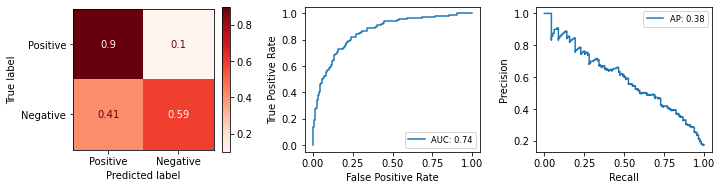

In [257]:
# copy the best MNB pipeline/model from the gridsearch (deep copy)
ros_LR_binary_withstemlem_pipe = clone(best_LR_binary_nostemlem_pipe)

# set tokenizer in the copy to use the function with stemming and lemmatization
ros_LR_binary_withstemlem_pipe.set_params(prep__vect__tokenizer=tokenize_lemma_stem)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(ros_LR_binary_withstemlem_pipe, Xros_train, yros_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
ros_LR_binary_withstemlem_pipe.fit(Xros_train, yros_train)

eval_clf_model(ros_LR_binary_withstemlem_pipe, X_test, y_test, Xros_train, 
               yros_train, labels=class_labels)

## Preprocessing for multi ROS

In [258]:
Xmros_train, ymros_train = ros.fit_resample(pd.DataFrame(Xm_train, 
                                        columns=['cleaned']), ym_train)

In [259]:
ymros_train.value_counts()

2    4298
1    4298
0    4298
Name: emotion, dtype: int64

In [260]:
print(len(Xmros_train))
print(len(ymros_train))

12894
12894


In [261]:
print(Xmros_train.shape)
print(ymros_train.shape)

(12894, 1)
(12894,)


In [262]:
Xmros_train = pd.Series(data=Xmros_train['cleaned'])
Xmros_train.shape

(12894,)

## ROS - Dummy Classifier

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.34      0.33      0.33      4298
           1       0.34      0.34      0.34      4298
           2       0.33      0.34      0.34      4298

    accuracy                           0.34     12894
   macro avg       0.34      0.34      0.34     12894
weighted avg       0.34      0.34      0.34     12894


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.06      0.30      0.10       114
           1       0.59      0.35      0.44      1074
           2       0.33      0.33      0.33       594

    accuracy                           0.34      1782
   macro avg       0.33      0.32      0.29      1782
weighted avg       0.47      0.34      0.38      1782


****************************** Training Scores ******************************
          

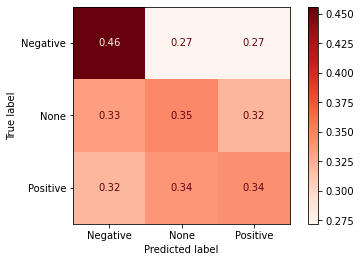

In [263]:
# pre-processing pipeline to transform into vectors
prep_pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=tweettokenizer.tokenize)),
    ('trans', TfidfTransformer())
])

# Let's make a baseline classifier using the dummy model
clf_pipe = Pipeline([
    ('prep', prep_pipe),
    ('clf', DummyClassifier(strategy='stratified'))
])

clf_pipe.fit(Xmros_train, ymros_train)

eval_clf_model(clf_pipe, Xm_test, ym_test, Xmros_train, ymros_train, 
               labels=mclass_labels)

## ROS - LR no stemming/lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.3s finished


All scores: [0.76237783 0.76615859 0.75491919 0.78473482 0.77696167]
Average x-validated score (recall): 0.769

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4298
           1       0.82      0.81      0.81      4298
           2       0.85      0.82      0.83      4298

    accuracy                           0.86     12894
   macro avg       0.86      0.86      0.86     12894
weighted avg       0.86      0.86      0.86     12894


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.24      0.50      0.32       114
           1       0.76      0.62      0.68      1074
           2       0.52      0.58      0.55       594

    accuracy                           0.60      1782
   macro avg       0.51      0.57      0.52      1782
weighted avg       0.65      0.6

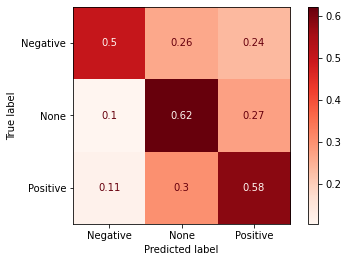

In [264]:
# copy the best MNB pipeline/model from the gridsearch (deep copy)
ros_LR_multiclass_nostemlem_pipe = clone(best_LR_multiclass_nostemlem_pipe)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(ros_LR_multiclass_nostemlem_pipe, Xmros_train, ymros_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
ros_LR_multiclass_nostemlem_pipe.fit(Xmros_train, ymros_train)

eval_clf_model(ros_LR_multiclass_nostemlem_pipe, Xm_test, ym_test, Xmros_train, 
               ymros_train, labels=mclass_labels)

Test balanced accuracy is a bit higher, although not much considering how much variation I've been seeing based on the train-test-splits.

Fewer Nones and Positives seem to be misclassified as Negative in this model, compared to the unsampled one.

## ROS - LR with stemming/lemmas

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.9s finished
/Users/jessicamiles/opt/anaconda3/envs/learn-env2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["it'"] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


All scores: [0.75927661 0.76150879 0.74793567 0.77892448 0.78006651]
Average x-validated score (recall macro): 0.766

****************************** Training Data ******************************
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      4298
           1       0.81      0.80      0.80      4298
           2       0.84      0.81      0.83      4298

    accuracy                           0.86     12894
   macro avg       0.86      0.86      0.86     12894
weighted avg       0.86      0.86      0.86     12894


****************************** Test Data ******************************
              precision    recall  f1-score   support

           0       0.25      0.52      0.34       114
           1       0.77      0.62      0.69      1074
           2       0.52      0.60      0.56       594

    accuracy                           0.61      1782
   macro avg       0.51      0.58      0.53      1782
weighted avg       0.65   

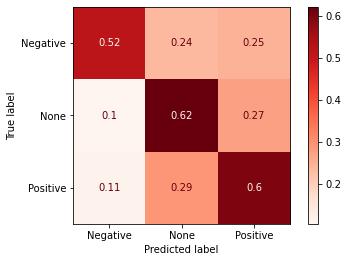

In [265]:
# copy the best MNB pipeline/model from the gridsearch (deep copy)
ros_LR_multiclass_withstemlem_pipe = clone(best_LR_multiclass_nostemlem_pipe)

# set tokenizer in the copy to use the function with stemming and lemmatization
ros_LR_multiclass_withstemlem_pipe.set_params(prep__vect__tokenizer=tokenize_lemma_stem)

# get cross_val_scores for best MNB model with stemming/lemmatization
xval = cross_val_score(ros_LR_multiclass_withstemlem_pipe, Xmros_train, ymros_train, 
                       scoring='recall_macro', n_jobs=-1, verbose=True)

print(f"All scores: {xval}")
print(f"Average x-validated score (recall macro): {np.round(np.mean(xval),3)}")
print()

# fit model to generate report
ros_LR_multiclass_withstemlem_pipe.fit(Xmros_train, ymros_train)

eval_clf_model(ros_LR_multiclass_withstemlem_pipe, Xm_test, ym_test, Xmros_train, 
               ymros_train, labels=mclass_labels)

# Best Models

Although testing random oversampling helped me verify my theory as to why the cross-validation and testing scores are so consistently lower than training, I don't think those models actually performed better than the models trained on un-resampled data. I prefer to optimize recall so that no one class performs much better than the other(s).

The best models therefore are the original Logistic Regression models trained on un-resampled data.

In [267]:
# pull out the best binary model from the Logistic Regression pipeline
best_binary = best_LR_binary_nostemlem_pipe.named_steps['clf']

# save out best binary model
model_path = 'models/'
joblib.dump(best_binary, f"{model_path}best_binary_model.joblib.gz")

# pull out the best multi-class model from the Logistic Regression pipeline
best_multi = best_LR_multiclass_nostemlem_pipe.named_steps['clf']

# save out best model for later, if needed
joblib.dump(best_multi, f"{model_path}best_multiclass_model.joblib.gz")

['models/best_multiclass_model.joblib.gz']

In terms of best parameters, the best models agreed on most things but differed in a few ways:

|Type|Doc Term Matrix Freq|Ngrams Range|Stopwords removal|Model params|
|---|---|---|---|---|
|Binary|TF-IDF|(1, 1)|Custom stopwords (minimal) and all punctuation except `?` and `!`|C=1, fit_intercept=False, solver=newton-cg|
|Multi-class|TF-IDF|(1, 2)|Custom stopwords (minimal) and all punctuation except `?` and `!`|C=0.1, fit_intercept=True, solver=newton-cg|

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Binary Coefficients

Let's review the coefficients for the binary classification problem first.

In [268]:
# get the feature names representing the words from the best pipeline
feature_names = best_LR_binary_nostemlem_pipe.named_steps['prep'].\
    named_steps['vect'].get_feature_names()
feature_names[:5]

['!', '##sxsw', '#10', '#100tc', '#106']

In [269]:
# convert logit coefficients from log odds to odds ratios
lr_odds = np.exp(best_binary.coef_[0])
lr_odds_s = pd.Series(lr_odds, index=feature_names)
lr_odds_s.sort_values(ascending=False)[:10]

not          13.835549
long         12.804669
#fail         8.231909
headaches     7.899227
hate          6.193692
iphone        5.842120
deleting      5.358117
because       5.202915
design        5.202376
battery       5.103678
dtype: float64

### Negative

In [270]:
# Create dataframe for odds greater than 1 (Negative). 
# Higher values represent greater odds of being negative
bin_neg = np.round(lr_odds_s.loc[lr_odds_s >= 1], 2).to_frame(
    name='Odds of Negative')
bin_neg.reset_index(inplace=True)
bin_neg.rename(columns={'index': 'Word'}, inplace=True)

# sort the dataframe by frequency
bin_neg.sort_values(by='Odds of Negative', ascending=False, inplace=True)
bin_neg.head()

,Word,Odds of Negative
996,not,13.84
895,long,12.80
35,#fail,8.23
732,headaches,7.90
728,hate,6.19


In [271]:
# Replace naughty words since I will be sharing this!
bin_neg['Word'].replace('fuck', 'f**k', inplace=True)
bin_neg['Word'].replace('fucking', 'f**king', inplace=True)

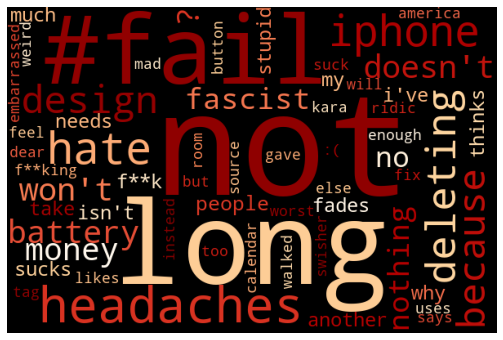

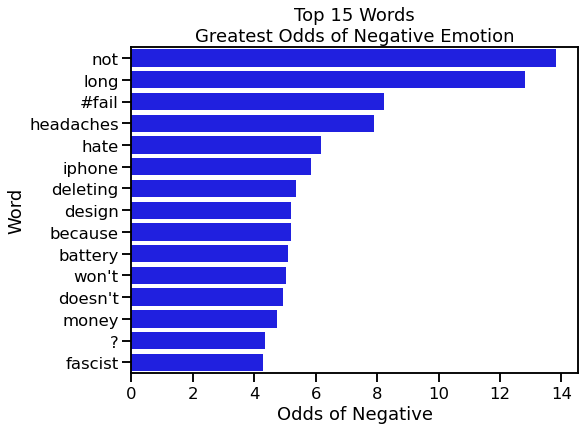

In [272]:
# Create visualizations for words with highest odds of negative emotion
generate_freqs_wordcloud(bin_neg, 'Word', 'Odds of Negative', cmap="OrRd", 
                   min_font_size=16)

plot_wordfreqs(bin_neg, 'Word', 'Odds of Negative', 15, 
               "Greatest Odds of Negative Emotion")

These definitely look like words associated with negative emotions, so I feel like the model is definitely picking up on the signal.

- `#fail` is a pretty general hashtag, but if I were working for Apple or Google, I would want to review tweets with my brand or product name in it as well as this hashtag to learn more
- `headaches`, `battery`, and `design` stand out as potentially being related to some feature or function of a device not working as expected
- `deleting` sounds like it might be related to an app, so I would check into what product or app is mentioned in these tweets
- `iphone` is pretty high up there, so Apple would probably want to review the tweets classified as negative and containing `iphone` to see what else is mentioned
- `long` features in both the top 15 words and word cloud. Out of context it doesn't sound like a negative word, but from what I've read while processing these, I'd guess this is referring to long lines that people described to get into an Apple pop-up store in Austin. 

`Long` is an example of a word that is a strong predictor of negative sentiment in this dataset, but may not be in another dataset, and would cause the model to not generalize well to future data if it consisted of tweets posted under different circumstances. 

In my opinion, it also demonstrates the challenge inherent in using human-labeled documents to train a supervised model, especially if the classes are somewhat complex to categorize. I would argue that although the pop-up store with the long line is an Apple store, the negative emotions in tweets about the long line aren't necessarily directed at Apple's brand or products. I imagine that people who think highly of the Apple brand and products might still use negative emotions to express frustration at the idea of waiting in a long line to visit the store. That may be interpreted differently by different human labelers.

### Positive

In [276]:
# Create dataframe for odds less than 1. 
# Higher values represent greater odds of being positive
bin_pos = np.round(1/(lr_odds_s.loc[lr_odds_s < 1]), 2).to_frame(
    name='Odds of Positive')
bin_pos.reset_index(inplace=True)
bin_pos.rename(columns={'index': 'Word'}, inplace=True)

# sort the dataframe by frequency
bin_pos.sort_values(by='Odds of Positive', ascending=False, inplace=True)
bin_pos.head()

,Word,Odds of Positive
0,!,51.02
2135,ipad,10.62
1700,free,10.05
1840,great,9.86
2732,party,7.29


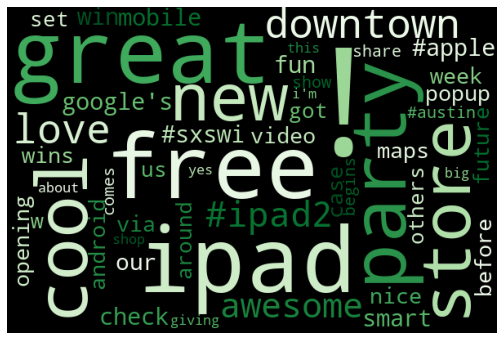

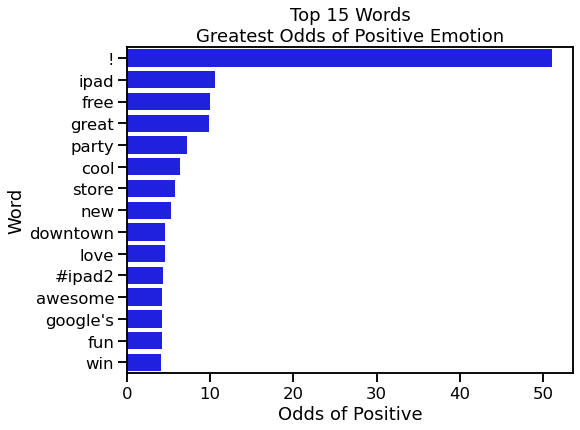

In [277]:
# Create visualizations for words with highest odds of positive emotion
generate_freqs_wordcloud(bin_pos, 'Word', 'Odds of Positive', cmap="Greens", 
                   min_font_size=16)

plot_wordfreqs(bin_pos, 'Word', 'Odds of Positive', 15, 
               "Greatest Odds of Positive Emotion")

And these definitely look like words associated with positive emotions.

- Perhaps unsurprisingly, an exclamation point in a tweet greatly increase the odds of it having positive emotions.
- `ipad` is the next most influential word for positive emotion, so in this corpus people are being positive about the iPad. They were tending to be more negative towards the iPhone. It sounds like Apple released the iPad2 shortly before this time period, and since `new` is also in the top predictors of positive emotion, it may be that people are excited about the new model.
- `free` is the next most influential word for positive emotion, which makes sense to me. Companies could review the tweets containing `free` to see what free items people liked best, in case there were multiple giveaways.
- `store` and `popup` are both in the word cloud. While there were probably some people tweeting negatively about the long line, there were also others who tweeted positively about the popup store.

## Multi-class Coefficients

In addition to reviewing the words that indicate highest odds of 'No emotion towards brand or product', I'm also interested in whether the models will agree on what tokens contribute the highest odds to Positive and Negative.

In [278]:
# get the feature names representing the words from the best pipeline
feature_names = best_LR_multiclass_nostemlem_pipe.named_steps['prep'].\
    named_steps['vect'].get_feature_names()
feature_names[:5]

['!', '! !', '! #agchat', '! #android', '! #androidsxsw']

### Negative

In [279]:
# convert logit coefficients from log odds to odds ratios
# index 0 is negative
lr_odds = np.exp(best_multi.coef_[0])
lr_odds_s = pd.Series(lr_odds, index=feature_names)

# Create dataframe for negative odds
multi_neg = np.round(lr_odds_s, 2).to_frame(name='Odds of Negative')
multi_neg.reset_index(inplace=True)
multi_neg.rename(columns={'index': 'Word'}, inplace=True)

# sort the dataframe by frequency
multi_neg.sort_values(by='Odds of Negative', ascending=False, inplace=True)
multi_neg.head()

,Word,Odds of Negative
30495,not,2.43
24040,iphone,2.33
22179,i,2.09
13742,design headaches,2.03
20974,headaches,2.01


In [280]:
# Replace naughty words since I will be sharing this!
multi_neg['Word'].replace('fuck', 'f**k', inplace=True)
multi_neg['Word'].replace('fucking', 'f**king', inplace=True)

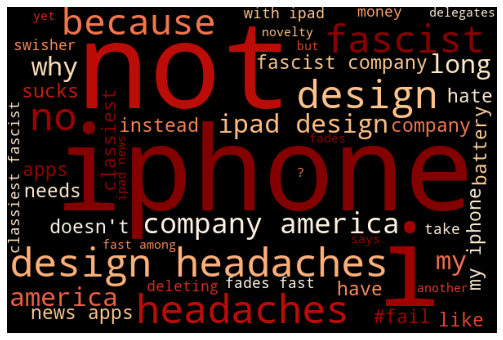

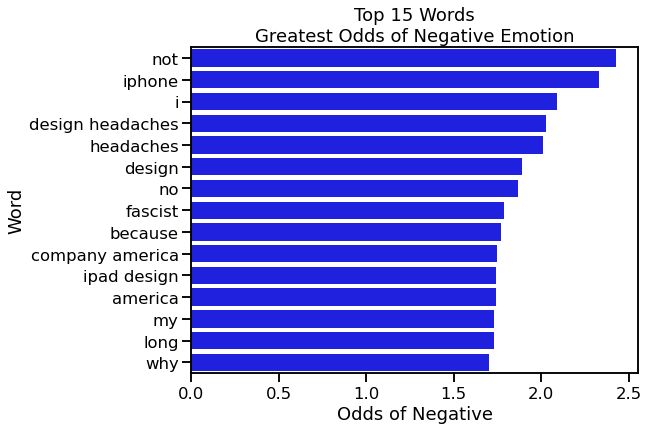

In [281]:
# Create visualizations for words with highest odds of negative emotion
generate_freqs_wordcloud(multi_neg, 'Word', 'Odds of Negative', cmap="OrRd", 
                   min_font_size=14)

plot_wordfreqs(multi_neg, 'Word', 'Odds of Negative', 15, 
               "Greatest Odds of Negative Emotion")

These mostly look like negative words, although `my` and `i` are pretty neutral. Many of these are familiar from the binary model, but the weights are different.

- `iphone` is the word with the greatest odds of  negative emotion, which is interesting. Apple would definitely want to look into that. It didn't even make it into the top 15 in the binary mode..
- `#fail` was the the second word in the top 15 for the binary model, but it's much less influential in the multi-class model. `Deleting` and `battery` have also dropped in feature importance.
- `headaches` and `design` were in the binary model, and here where we had bigrams as well as unigrams we can see `design headaches` as well as `ipad design`. This is more informative than the unigrams.


### Positive

In [286]:
# convert logit coefficients from log odds to odds ratios
# index 2 is positive
lr_odds = np.exp(best_multi.coef_[2])
lr_odds_s = pd.Series(lr_odds, index=feature_names)

# Create dataframe for positive odds
multi_pos = np.round(lr_odds_s, 2).to_frame(name='Odds of Positive')
multi_pos.reset_index(inplace=True)
multi_pos.rename(columns={'index': 'Word'}, inplace=True)

# sort the dataframe by frequency
multi_pos.sort_values(by='Odds of Positive', ascending=False, inplace=True)
multi_pos.head()

,Word,Odds of Positive
0,!,5.49
23449,ipad,1.98
19817,great,1.75
12457,cool,1.72
8046,awesome,1.64


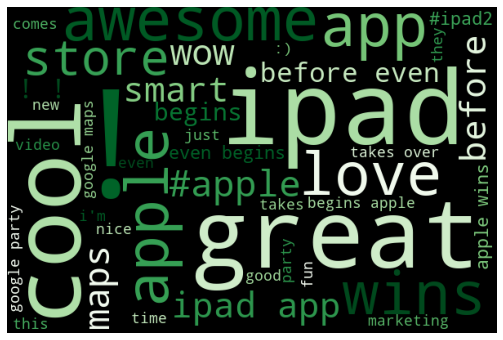

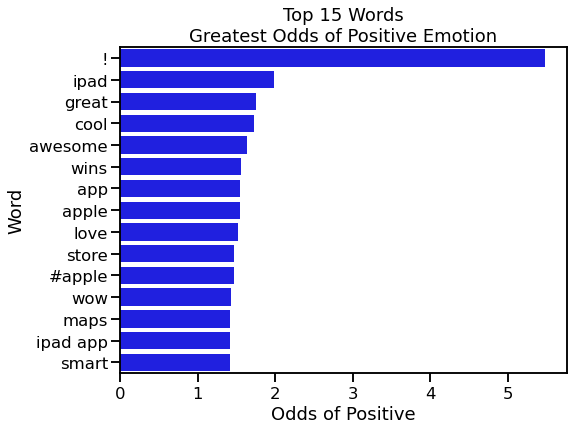

In [287]:
# Create visualizations for words with highest odds of positive emotion
generate_freqs_wordcloud(multi_pos, 'Word', 'Odds of Positive', cmap="Greens", 
                   min_font_size=16)

plot_wordfreqs(multi_pos, 'Word', 'Odds of Positive', 15, 
               "Greatest Odds of Positive Emotion")

These seem to agree with the binary model pretty well. 

- An exclamation point is still the top predictor of positive emotion.
- `free` doesn't make it into the top 15 here, although I see it pretty small in the word cloud.
- I see more brand names in this positive word cloud, such as `apple`, `#apple`, and `google party`.

### No emotion

In [284]:
# convert logit coefficients from log odds to odds ratios
# index 1 is no emotion
lr_odds = np.exp(best_multi.coef_[1])
lr_odds_s = pd.Series(lr_odds, index=feature_names)

# Create dataframe for no emotion odds
# only odds over 1, since anything less than 1 is not more likely
multi_none = np.round(lr_odds_s.loc[lr_odds_s >= 1], 2).\
    to_frame(name='Odds of No Emotion')
multi_none.reset_index(inplace=True)
multi_none.rename(columns={'index': 'Word'}, inplace=True)

# sort the dataframe by frequency
multi_none.sort_values(by='Odds of No Emotion', ascending=False, inplace=True)
multi_none.head()

,Word,Odds of No Emotion
2749,?,1.66
9948,free,1.53
869,#google,1.52
23601,today,1.48
22145,store,1.48


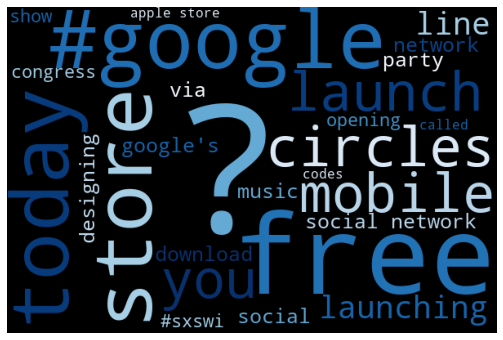

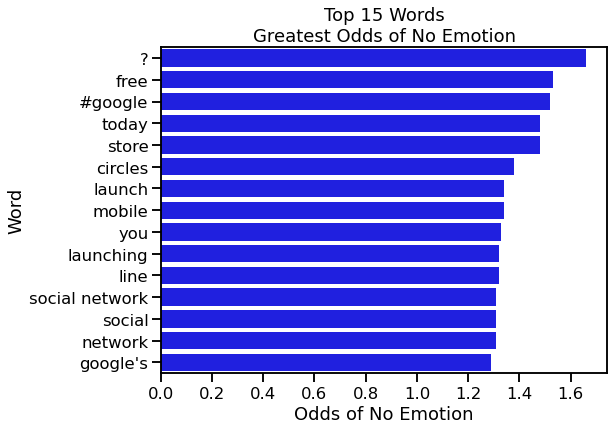

In [285]:
# Create visualizations for words with highest odds of positive emotion
generate_freqs_wordcloud(multi_none, 'Word', 'Odds of No Emotion', cmap="Blues", 
                   min_font_size=16)

plot_wordfreqs(multi_none, 'Word', 'Odds of No Emotion', 15, 
               "Greatest Odds of No Emotion")

- Some of the words that were associated with positive emotion in the binary model are now associated with No emotion in the multi-class model. Examples include `free` and `store`.
- `line` was associated with negative emotion in the binary model, but here is no emotion.
- We definitely have brands being mentioned such as `google`, `apple`. That must mean that people are mentioning brands but not expressing any emotion that the people who labeled the dataset could discern.

One big thing that sticks out is the scale of odds in the multi-class versus binary model. The odds for top 15 ngrams are mugh higher in the binary model than for multi-class. It makes sense that the more classes a model is trying to predict, fewer words it will identify as being strong predictors of each class, and the less "sure" it will be about one class versus another.

## Investigating the labeling

An important factor in interpreting these results the quality of the labeling used to train the models.

This corpus was labeled by CrowdFlower (now called Figure Eight), meaning human beings did the labeling. 
- I was not able to determine who made up the group of labels (whether they do this professionally, were volunteers, their level of English reading comprehension, etc.) 
- I also could not determine what, if any, steps were taken after the labeling to perform quality control checks or standardization on the accuracy and consistency of the labels applied. Since there were some still left labeled 'I can't tell' I think it's likely there was no QC step.
- We don't know how clear the instructions to the labelers were. Deciding sentiment alone is fairly easy, but the labels here are somewhat convoluted since people need to put positive or negative sentiment that is NOT towards a brand or product, AND neutral sentiment towards a brand or product in a single category. Without clear instructions, some people may have simply tagged based on sentiment.
- Finally, I have definitely noticed some tweets labeled as having sentiment towards a brand or product, but the sentiment is directed towards a third party iPhone or Android app, not a core function of the operating system or even an app developed by Apple or Google. I would imagine that representatives from Apple or Google probably value feedback about the products and services they actually put out, versus apps that run on their products, and over which they have little to no quality control.

Although human beings are certainly better at detecting sentiment and emotion than computer systems, there are no objective standards for deciding sentiment and emotion. In other words, the ground truth represented by these labels is still fairly subjective, adding an additional layer of noise to the data on top of the existing noise related to general differences in how people use words.

It is not only the interpretation of sentiment which is subjective and thus prone to noisy labeling by the humans who classify the data. Sentiment is also inherently noisy in general because it is not a black or white concept; highly positive or highly negative. Both positive and negative sentiments may be expressed on gradient scales, with a very muddy neutral center.

It seems human labels are only about 80% accurate, based on some [quick research](https://www.informationweek.com/software/information-management/expert-analysis-is-sentiment-analysis-an-80%C3%B1solution/d/d-id/1087919) I did. So our models' performance should be interpreted with the understanding that a dummy classifier performance is the minimum, and 80% is as good as humans would do. In fact, it's possible some of the tweets our model supposedly mis-classified are actually correct and it was the human-applied label that was inaccurate!

### Comparing Model Predictions to Human Labels

In [328]:
# Get predictions for X (binary problem)
binary_preds = best_LR_binary_nostemlem_pipe.predict(X)
binary_preds_prob = best_LR_binary_nostemlem_pipe.predict_proba(X)

# Get predictions for Xm (multi-class problem)
multi_preds = best_LR_multiclass_nostemlem_pipe.predict(Xm)
multi_preds_prob = best_LR_multiclass_nostemlem_pipe.predict_proba(Xm)

print(binary_preds[:5])
print(multi_preds[:5])
print()
print(binary_preds_prob[:5])
print(multi_preds_prob[:5])

[1 0 1 1 0]
[0 2 2 0 2]

[[0.20261891 0.79738109]
 [0.69476519 0.30523481]
 [0.39183933 0.60816067]
 [0.25582282 0.74417718]
 [0.7069954  0.2930046 ]]
[[0.4749911  0.23453799 0.29047091]
 [0.31294731 0.29588323 0.39116946]
 [0.32835884 0.29419532 0.37744584]
 [0.50774185 0.22921484 0.26304332]
 [0.27680566 0.3487885  0.37440583]]


In [330]:
X_df = X.to_frame('cleaned')
X_df['binary_pred'] = binary_preds
X_df.tail()

,cleaned,binary_pred
9049,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,1
9051,"""papyrus...sort of like the ipad"" - nice! Lol! #SXSW Lavelle",0
9052,"Diller says Google TV ""might be run over by the PlayStation and the Xbox, which are essentially ready today."" #sxsw #diller",1
9057,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,0
9060,Ipad everywhere. #SXSW {link},0


In [331]:
Xm_df = Xm.to_frame('cleaned')
Xm_df['multi_pred'] = multi_preds
Xm_df.tail()

,cleaned,multi_pred
9060,Ipad everywhere. #SXSW {link},2
9061,"Wave, buzz... RT @mention We interrupt your regularly scheduled #sxsw geek programming with big news {link} #google #circles",1
9062,"Google's Zeiger, a physician never reported potential AE. Yet FDA relies on physicians. ""We're operating w/out data."" #sxsw #health2dev",1
9063,Some Verizon iPhone customers complained their time fell back an hour this weekend. Of course they were the New Yorkers who attended #SXSW.,2
9064,_ _ _ RT @mention Google Tests Check-in Offers At #SXSW {link},1


In [336]:
# join preds into original df
df = df.join([X_df[['binary_pred']], Xm_df[['multi_pred']]])
df.head()

,tweet_text,product,emotion,cleaned,hashtags,raw_token_count,binary_pred,multi_pred
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",#RISE_Austin #SXSW,28,1.0,0.0
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",#SXSW,26,0.0,2.0
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.,#iPad #SXSW,16,1.0,2.0
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,#sxsw,16,1.0,0.0
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",#SXSW,27,0.0,2.0


In [341]:
# map text classes onto integers
df['multi_pred'] = df['multi_pred'].map(lambda x: multi_intkey[x], 
                                        na_action='ignore')
df['binary_pred'] = df['binary_pred'].map(lambda x: binary_intkey[x], 
                                          na_action='ignore')
df.head()

,tweet_text,product,emotion,cleaned,hashtags,raw_token_count,binary_pred,multi_pred
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion,".@wesley83 I have a 3G iPhone. After hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",#RISE_Austin #SXSW,28,Negative emotion,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",#SXSW,26,Positive emotion,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion,@swonderlin Can not wait for #iPad also. They should sale them down at #SXSW.,#iPad #SXSW,16,Negative emotion,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,#sxsw,16,Negative emotion,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) & Matt Mullenweg (Wordpress)",#SXSW,27,Positive emotion,Positive emotion


In [351]:
# Check out some examples of incorrect predictions from binary model
df.loc[(df['emotion'] != df['binary_pred']) & 
       (df['emotion'].isin(binary_strkey.keys())), 
       ['tweet_text', 'emotion', 'binary_pred']]#[50:60]


,tweet_text,emotion,binary_pred
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,Positive emotion,Negative emotion
9,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Positive emotion,Negative emotion
63,Again? RT @mention Line at the Apple store is insane.. #sxsw,Negative emotion,Positive emotion
67,"Boooo! RT @mention Flipboard is developing an iPhone version, not Android, says @mention #sxsw",Negative emotion,Positive emotion
75,I love my @mention iPhone case from #Sxsw but I can't get my phone out of it #fail,Positive emotion,Negative emotion
...,...,...,...
8972,Dropped my MacBook pro as I was walking into #sxsw. iPad 2 sounding pretty appealing right now. Somehow I will adapt and overcome.,Positive emotion,Negative emotion
8978,Creativity prompt: use Google maps to virtually take a walk you used to take as a kid; see what memories come up. (courtesy @mention #SXSW,Positive emotion,Negative emotion
9017,@mention you are my favorite-- thanks for coming to @mention -- when you getting an iPhone again?? #SXSW,Positive emotion,Negative emotion
9043,"what are your essentials for #SxSW? Mine? pocket camera, laptop, iPad, extra cords...",Positive emotion,Negative emotion


Some of the binary model's predictions I definitely do disagree with, where I agree with the original human labels.
- Examples are rows 2, 75, 8978, 9049

But others I actually think should be neutral. I disagree with the human label, and the binary model is just doing the best it can to choose between the only options it knows: negative and positive.
- Examples are rows 63, 67, 8972, 9017, 9043

A few I think should be either positive or negative, and the binary model got it right while the human labels are wrong.
- Examples are row 9

In [349]:
# Check out some examples of incorrect predictions from multi model
df.loc[(df['emotion'] != df['multi_pred']) & 
       (df['emotion'].isin(multi_strkey.keys())), 
       ['tweet_text', 'emotion', 'multi_pred']]

,tweet_text,emotion,multi_pred
9,Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1. #fail,Positive emotion,Negative emotion
15,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,No emotion toward brand or product,Positive emotion
42,Mashable! - The iPad 2 Takes Over SXSW [VIDEO] #ipad #sxsw #gadgets {link},No emotion toward brand or product,Positive emotion
46,HOORAY RT ÛÏ@mention Apple Is Opening A Pop-Up Store In Austin For #SXSW | @mention {link},Positive emotion,No emotion toward brand or product
54,ÛÏ@mention @mention talking about {link} - Google's effort to allow users to have open systems #bettercloud #sxswÛ,Positive emotion,No emotion toward brand or product
...,...,...,...
9043,"what are your essentials for #SxSW? Mine? pocket camera, laptop, iPad, extra cords...",Positive emotion,No emotion toward brand or product
9049,@mention your PR guy just convinced me to switch back to iPhone. Great #sxsw coverage. #princess,Positive emotion,Negative emotion
9057,I've always used Camera+ for my iPhone b/c it has an image stabilizer mode. Suggestions for an iPad cam app w/ same feature? #SXSW #SXSWi,Positive emotion,Negative emotion
9059,"@mention Yup, but I don't have a third app yet. I'm on Android, any suggestions? #SXSW CC: @mention",No emotion toward brand or product,Negative emotion


I see some of these that I think the multi-class model classified more accurately, and some that it missed and I agree with the human labels instead.

This is clearly not an exact science!

## Final Model Performance

The best performing models I tried were the ones generated with original training data, not randomly oversampled to balance the classes.

### Binary Problem
The best binary model had a balanced accuracy rate of 75% on test data, so it was able to correctly classify tweets 75% of the time. However, this is an average: the model performed better predicting positive emotions than negative.
- About ~40% of negative tweets were mis-classified as positive, with ~60% of negative tweets being classified correctly
- Only about 10% of positive tweets were misclassified as negative, with about 90% of positive tweets being classified correctly.

### Multi-class Problem
The best multi-class model had a balanced accuracy rate of ~62% on test data. The model was generally better at classifying tweets with No brand emotion or  Positive brand emotion compared to tweets with Negative brand emotion, although the gap was not as wide as in the binary problem.
- For No emotion and Positive, the model made the correct classification about 65% of the time. About 25-28% of the time, it confused No emotion with Positive, or vice versa. It only misclassified No emotion or Positive as Negative ~8-10% of the time.
- For Negative, the model made the correct classification about 58% of the time, so a slightly lower rate than the other classes. ~20-22% of of the time, Negative tweets were confused for Positive or No emotion, about evenly split between them.

### Generalization
I think these models would perform better on another unseen tweet corpus than random guessing, especially if it was related to Apple and Google products and brands. Many of the top predictors for positive and negative are representative of the target sentiment in general, not related to SXSW.

However, some are definitely specific to the SXSW events, such as the long line at the Apple popup store, so this makes the model less generalizable. It's also very specific to Apple and Google




# CONCLUSIONS & RECOMMENDATIONS

As a proof-of-concept, I think I've demonstrated that even simple models such as Logistic Regression can be trained on labeled data to predict sentiment more accurately than random guessing.

Since the Logistic Regression models are easy to interpret, I think they could provide useful insights for business stakeholders at a company looking to inform marketing and product strategies. My approach would probably be to use the multi-class model to separate positive and negative tweets, and use the binary model as a second step to pull out the most important ngrams.

Although these simple models only give us feature importances of ngrams, if we built a simple tool to search for each ngram as a keyword in tweets, we could pull samples for subject matter experts to review and interpret before determining any next steps.

The biggest challenge would be finding and labeling a corpus for training that would be generalizable on future data. The model trained on this example dataset would probably still be better than random guessing on other Apple/Google tweets, but probably less accurate than it was on this data. It would also be important to consider the classification labels carefully, and provide clear instructions to the humans doing the labeling. The classes used for this dataset are not very clearly delineated in my opinion, and it would be easy for human labels to misclassify due to not accurately understanding the nature of the task.

## Recommended Next Steps

### Test tiered models

I trained and evaluated the multi-class models separately, but since my suggestion is to use multi-class predictions to feed into the binary model, I would need to build and test that process to confirm the binary model performs as well on positive and negative tweets classified by the MC model as it does on the human-labeled tweets.

### Test more complex models

Try more complex model machine learning models and options, such as SVM, CNN, pre-trained vocabulary, and other pre-processing steps like skip-grams to see if they can do a better job at the multi-class problem. Performance of the best Logistic Regression models from this POC would serve as a baseline to determine whether the cost/time needed to implement more complex models would be worth the performance gain.

Even if it's less interpretable, perhaps a more complex multi-class model could help sift the tweets with emotions about brands or products versus those that have no emotion. The tweets with emotions could be fed into a more interpretable binary model to determine positive or negative, and the ngrams that contribute to both.

In a real-world scenario, I would do such a POC on company-specific tweets, then have subject matter experts review results to see whether the feature importances brought to light anything they weren't already aware of. I think these models will naturally highlight the strongest and most common positive and negative ngrams, so in practice they may mostly reveal insights known through other channels. SMEs would need to confirm whether the insights from the models are useful.
